# Análise de Dados Exploratória

<!-- Fontes:
- https://www.linkedin.com/pulse/entenda-o-que-%C3%A9-lei-rouanet-ficarte-fnc-e-oque-fiscal-oliveira/?originalSubdomain=pt
- https://www.gov.br/cultura/pt-br/centrais-de-conteudo/marcas-e-logotipos/copy_of_ManualdoProponenteMduloIApresentaodePropostas1.pdf
- https://portaldoincentivo.com.br/visitors/incentive_laws/1 -->

## 1. Coleta e carregamento de dados

>Os dados utilizados são públicos, porém foram utilizados somente para fins de estudo.

**Obtenção do dataset da Lei Rouanet, disponibilizado pelo Ministério da Cultura [(SALIC)](https://api.salic.cultura.gov.br/doc/)**

Eu desenvolvi um script utilizando as bibliotecas `os`, `request`, `json` e `pandas` para extrair os dados da API referentes aos projetos, propostas, proponentes, incentivadores e fornecedores. Os dados foram salvos em arquivos no formato `xsls`. Devido ao seu tamanho, não foi possível hospedá-los neste repositório. Em vez disso, eu os incluí em uma pasta no Google Drive e compartilhei os links em um arquivo `csv`. 

Esses arquivos podem ser baixados manualmente ou usando um script que criei com as bibliotecas `os` e `gdown`. 

**Carregamento dos dados em um DataFrame do pandas**

In [1]:
from os import path

import numpy as np
import pandas as pd

import geobr
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_projetos_original = pd.read_excel(path.abspath("datasets/projetos.xlsx"))
df_projetos = df_projetos_original.copy()
# df_proponentes = pd.read_excel(path.abspath("datasets/proponentes.xlsx"))
# df_incentivadores = pd.read_excel(path.abspath("datasets/incentivadores.xlsx"))

In [3]:
warnings.filterwarnings("ignore")

####

## 2. Exploração Inicial

**Análise preliminar para entender a estrutura do dataset, tipos de variáveis e dados disponíveis**

In [4]:
df_projetos.columns

Index(['etapa', 'providencia', 'area', 'enquadramento', 'objetivos',
       'ficha_tecnica', 'situacao', 'outras_fontes', 'acessibilidade',
       'sinopse', 'nome', 'cgccpf', 'mecanismo', '_links', 'segmento',
       'PRONAC', 'estrategia_execucao', 'valor_aprovado', 'justificativa',
       'resumo', 'valor_solicitado', 'especificacao_tecnica', 'municipio',
       'data_termino', 'UF', 'impacto_ambiental', 'democratizacao',
       'valor_projeto', 'proponente', 'ano_projeto', 'data_inicio',
       'valor_captado', 'valor_proposta'],
      dtype='object')

Colunas interessantes para a análise dos **projetos**: 

- `providencia`
- `objetivos`
- `situacao`
- `area`
- `mecanismo`
- `enquadramento`
- `valor_aprovado`
- `valor_captado`
- `UF`
- `municipio`
- `ano_projeto`
- `data_termino`
- `data_inicio`

In [5]:
# df_proponentes.columns

Colunas interessantes para a análise dos **proponentes**: 

- `tipo_pessoa`
- `responsavel`
- `UF`
- `municipio`
- `total_captado`

In [6]:
# df_incentivadores.columns

Colunas interessantes para a análise dos **incentivadores**: 

- `nome`
- `tipo_pessoa`
- `total_doado`
- `UF`
- `municipio`

####

## 3. Limpeza e Preparação dos Dados

### 3.1. Tratamento de valores ausentes, inconsistências ou duplicatas

In [7]:
# reduzindo os dfs para conter apenas as informações necessárias
df_projetos = df_projetos[["providencia",
                     "objetivos",
                     "situacao",
                     "area",
                     "mecanismo",
                     "enquadramento",
                     "valor_aprovado",
                     "valor_captado",
                     "UF",
                     "municipio", 
                     "ano_projeto",
                     "data_termino",
                     "data_inicio"]].sort_values("UF")

# df_proponentes = df_proponentes[["tipo_pessoa",
#                            "responsavel",
#                            "UF",
#                            "municipio",
#                            "total_captado"]].sort_values("UF")

# df_incentivadores = df_incentivadores[["nome",
#                                     "tipo_pessoa",
#                                     "total_doado",
#                                     "UF",
#                                     "municipio"]].sort_values("UF")

In [8]:
# removendo linhas duplicadas
df_projetos.drop_duplicates(inplace=True)

In [9]:
# removendo projetos com todos os valores menores ou iguais a zero OU indeferidos ou arquivados
filtro_valor_aprovado_zerado = df_projetos["valor_aprovado"] <= 0
filtro_valor_captado_zerado = df_projetos["valor_captado"] <= 0
situacoes_negativas = ["arquivado", "arquivamento", "indeferido", "inadimplen"]
filtro_situacao_negativa = df_projetos["situacao"].str.lower().str.contains("|".join(situacoes_negativas))
conjunto_filtros_negativos = ((filtro_valor_aprovado_zerado & filtro_valor_captado_zerado) | filtro_situacao_negativa)

# com exceção daqueles que tiveram captação acima de zero E foram encerrados normalmente
filtro_valor_captado_positivo = df_projetos["valor_captado"] > 0
situacoes_positivas = ['captação/execução encerradas', "recursos transferidos"]
filtro_situacao_positiva = df_projetos["situacao"].str.lower().str.contains("|".join(situacoes_positivas))
conjuntos_filtros_positivos = filtro_valor_captado_positivo & filtro_situacao_positiva

df_projetos = df_projetos[~(conjunto_filtros_negativos ^ conjuntos_filtros_positivos)]

# existem somente 3 projetos arquivados com valor de captação maior que zero
# suas providências foram analisadas e confere o arquivamento
# teste[(teste["situacao"] == "Arquivado") & (teste["valor_captado"] > 0)]["providencia"].unique()

In [10]:
# removendo colunas de providência e situação (não serão mais utilizadas)
df_projetos.drop("providencia", axis=1, inplace=True)
df_projetos.drop("situacao", axis=1, inplace=True)

In [11]:
# padronizando ano para formato 20XX
df_projetos["ano_projeto"] = 2000 + df_projetos["ano_projeto"]

In [12]:
# removendo datas inválidas
datas_invalidas = ["8201-08-28", "3204-03-31", "3015-01-31", "2424-12-31", "7014-10-10"]
filtro_data_termino_invalida = df_projetos["data_termino"].str.contains("|".join(datas_invalidas))

if filtro_data_termino_invalida.any(axis=None):
    for data in datas_invalidas:
        filtro_data_termino_igual_data_invalida = df_projetos["data_termino"] == data
        df_projetos.loc[filtro_data_termino_igual_data_invalida, "data_termino"] = np.nan

In [13]:
# convertendo datas para datetime
df_projetos["data_inicio"] = pd.to_datetime(df_projetos["data_inicio"])
df_projetos["data_termino"] = pd.to_datetime(df_projetos["data_termino"])

In [14]:
# removendo projetos cuja diferença entre a data de início do projeto e o ano de início do projeto seja menor que -1
filtro_grande_diferenca_data_inicio_ano_projeto = (df_projetos["data_inicio"].dt.year - df_projetos["ano_projeto"]) < -1
df_projetos = df_projetos[~filtro_grande_diferenca_data_inicio_ano_projeto]

In [15]:
# padronizando formato dos municípios (title.()) e removendo linhas com nomes errados
df_projetos["municipio"] = df_projetos["municipio"].str.title()

In [16]:
# removendo projetos com municípios nulos e inválidos
filtro_municipio_nan = df_projetos["municipio"].isnull()
filtro_municipio_isdigit = df_projetos["municipio"].str.isdigit()

df_projetos = df_projetos[~(filtro_municipio_nan | filtro_municipio_isdigit)]

In [17]:
# removendo tabulação do final dos nomes dos municípios
filtro_municipio_contem_tab = df_projetos["municipio"].str.contains("\t")
df_projetos.loc[filtro_municipio_contem_tab, "municipio"] = df_projetos.loc[filtro_municipio_contem_tab, "municipio"].str[:-1]

In [18]:
# corrigindo UFs erradas das capitais
filtro_municipio_salvador_uf_diferente = (df_projetos["municipio"] == "Salvador") & (df_projetos["UF"] != "BA")
filtro_municipio_fortaleza_uf_diferente = (df_projetos["municipio"] == "Fortaleza") & (df_projetos["UF"] != "CE")
filtro_municipio_brasilia_uf_diferente = (df_projetos["municipio"] == "Brasília") & (df_projetos["UF"] != "DF")
filtro_municipio_vitoria_uf_diferente = (df_projetos["municipio"] == "Vitória") & (df_projetos["UF"] != "ES")
filtro_municipio_sao_luis_uf_diferente = (df_projetos["municipio"] == "São Luís") & (df_projetos["UF"] != "MA")
filtro_municipio_campo_grande_uf_diferente = (df_projetos["municipio"] == "Campo Grande") & (df_projetos["UF"] != "MS")
filtro_municipio_bh_uf_diferente = (df_projetos["municipio"] == "Belo Horizonte") & (df_projetos["UF"] != "MG")
filtro_municipio_belem_uf_diferente = (df_projetos["municipio"] == "Belém") & (df_projetos["UF"] != "PA")
filtro_municipio_joao_pessoa_uf_diferente = (df_projetos["municipio"] == "João Pessoa") & (df_projetos["UF"] != "PB")
filtro_municipio_curitiba_uf_diferente = (df_projetos["municipio"] == "Curitiba") & (df_projetos["UF"] != "PR")
filtro_municipio_teresina_uf_diferente = (df_projetos["municipio"] == "Teresina") & (df_projetos["UF"] != "PI")
filtro_municipio_rj_uf_diferente = (df_projetos["municipio"] == "Rio De Janeiro") & (df_projetos["UF"] != "RJ")
filtro_municipio_porto_alegre_uf_diferente = (df_projetos["municipio"] == "Porto Alegre") & (df_projetos["UF"] != "RS")
filtro_municipio_porto_velho_uf_diferente = (df_projetos["municipio"] == "Porto Velho") & (df_projetos["UF"] != "RO")
filtro_municipio_floripa_uf_diferente = (df_projetos["municipio"] == "Florianópolis") & (df_projetos["UF"] != "SC")
filtro_municipio_sp_uf_diferente = (df_projetos["municipio"] == "São Paulo") & (df_projetos["UF"] != "SP")
filtro_municipio_palmas_uf_diferente = (df_projetos["municipio"] == "Palmas") & (df_projetos["UF"] != "TO")

df_projetos.loc[filtro_municipio_salvador_uf_diferente, "UF"] = "BA"
df_projetos.loc[filtro_municipio_fortaleza_uf_diferente, "UF"] = "CE"
df_projetos.loc[filtro_municipio_brasilia_uf_diferente, "UF"] = "DF"
df_projetos.loc[filtro_municipio_vitoria_uf_diferente, "UF"] = "ES"
df_projetos.loc[filtro_municipio_sao_luis_uf_diferente, "UF"] = "MA"
df_projetos.loc[filtro_municipio_campo_grande_uf_diferente, "UF"] = "MS"
df_projetos.loc[filtro_municipio_bh_uf_diferente, "UF"] = "MG"
df_projetos.loc[filtro_municipio_belem_uf_diferente, "UF"] = "PA"
df_projetos.loc[filtro_municipio_joao_pessoa_uf_diferente, "UF"] = "PB"
df_projetos.loc[filtro_municipio_curitiba_uf_diferente, "UF"] = "PR"
df_projetos.loc[filtro_municipio_teresina_uf_diferente, "UF"] = "PI"
df_projetos.loc[filtro_municipio_rj_uf_diferente, "UF"] = "RJ"
df_projetos.loc[filtro_municipio_porto_alegre_uf_diferente, "UF"] = "RS"
df_projetos.loc[filtro_municipio_porto_velho_uf_diferente, "UF"] = "RO"
df_projetos.loc[filtro_municipio_floripa_uf_diferente, "UF"] = "SC"
df_projetos.loc[filtro_municipio_sp_uf_diferente, "UF"] = "SP"
df_projetos.loc[filtro_municipio_palmas_uf_diferente, "UF"] = "TO"

In [19]:
# corrigindo UFs erradas de algumas cidades erradas -> importante para análise do estado de SP mais para frente
filtro_municipio_cariacica_uf_diferente = (df_projetos["municipio"] == "Cariacica") & (df_projetos["UF"] != "ES")
filtro_municipio_pirenopolis_uf_diferente = (df_projetos["municipio"] == "Pirenópolis") & (df_projetos["UF"] != "GO")
filtro_municipio_tiradentes_uf_diferente = (df_projetos["municipio"] == "Tiradentes") & (df_projetos["UF"] != "MG")
filtro_municipio_horizontina_uf_diferente = (df_projetos["municipio"] == "Horizontina") & (df_projetos["UF"] != "RS")
filtro_municipio_santa_cruz_cabralia_uf_diferente = (df_projetos["municipio"] == "Santa Cruz Cabrália") & (df_projetos["UF"] != "BA")
filtro_municipio_sao_jose_uf_diferente = (df_projetos["municipio"] == "São José") & (df_projetos["UF"] != "SC")
filtro_municipio_canela_uf_diferente = (df_projetos["municipio"] == "Canela") & (df_projetos["UF"] != "RS")
filtro_municipio_casca_uf_diferente = (df_projetos["municipio"] == "Casca") & (df_projetos["UF"] != "RS")
filtro_municipio_parati_uf_diferente = (df_projetos["municipio"] == "Parati") & (df_projetos["UF"] != "RJ")
filtro_municipio_conselheiro_lafaiete_uf_diferente = (df_projetos["municipio"] == "Conselheiro Lafaiete") & (df_projetos["UF"] != "MG")
filtro_municipio_londrina_uf_diferente = (df_projetos["municipio"] == "Londrina") & (df_projetos["UF"] != "PR")
filtro_municipio_santa_maria_uf_diferente = (df_projetos["municipio"] == "Santa Maria") & (df_projetos["UF"] != "RS")

df_projetos.loc[filtro_municipio_cariacica_uf_diferente, "UF"] = "ES"
df_projetos.loc[filtro_municipio_pirenopolis_uf_diferente, "UF"] = "GO"
df_projetos.loc[filtro_municipio_tiradentes_uf_diferente, "UF"] = "MG"
df_projetos.loc[filtro_municipio_horizontina_uf_diferente, "UF"] = "RS"
df_projetos.loc[filtro_municipio_santa_cruz_cabralia_uf_diferente, "UF"] = "BA"
df_projetos.loc[filtro_municipio_sao_jose_uf_diferente, "UF"] = "SC"
df_projetos.loc[filtro_municipio_canela_uf_diferente, "UF"] = "RS"
df_projetos.loc[filtro_municipio_casca_uf_diferente, "UF"] = "RS"
df_projetos.loc[filtro_municipio_parati_uf_diferente, "UF"] = "RJ"
df_projetos.loc[filtro_municipio_conselheiro_lafaiete_uf_diferente, "UF"] = "MG"
df_projetos.loc[filtro_municipio_londrina_uf_diferente, "UF"] = "PR"
df_projetos.loc[filtro_municipio_santa_maria_uf_diferente, "UF"] = "RS"

In [20]:
# corrigindo nomes dos municípios de SP -> importante para análise do estado de SP mais para frente
df_projetos.loc[df_projetos["municipio"] == "Olimpia", "municipio"] = "Olímpia"
df_projetos.loc[df_projetos["municipio"] == "Tremembe", "municipio"] = "Tremembé"
df_projetos.loc[df_projetos["municipio"] == "Bonfim Paulista", "municipio"] = "Ribeirão Preto"
df_projetos.loc[df_projetos["municipio"] == "Iepe", "municipio"] = "Iepê"
df_projetos.loc[df_projetos["municipio"] == "Guaruja", "municipio"] = "Guarujá"
df_projetos.loc[df_projetos["municipio"] == "Peruibe", "municipio"] = "Peruíbe"

# corrigindo nomes dos municípios de RJ
df_projetos.loc[df_projetos["municipio"] == "Parati", "municipio"] = "Paraty"

In [21]:
# removendo restante dos dados faltantes
df_projetos.dropna(inplace=True)

In [22]:
# ajustando index após remoções
df_projetos.set_index(np.arange(0, df_projetos.shape[0]), inplace=True)

Tratamento dos dados dos proponentes:

In [23]:
# uf_invalidos = ["  ", "35", "33", "41", "51", "15", "26", "53"]
# df_proponentes = df_proponentes[~(df_proponentes["UF"].str.contains("|".join(uf_invalidos))) & ~(df_proponentes["responsavel"] == '.')]

Tratamento dos dados dos incentivadores:

In [24]:
# uf_invalidos = ["  ", "13", "15", "17", "21", "22", "23", "25", "26", "27", "28", "29", "31", "32", "33", "35", "41", "42", "43", "50", "51", "52", "53", "NI"]
# df_incentivadores = df_incentivadores[~df_incentivadores["UF"].str.contains("|".join(uf_invalidos))]

#####

### 3.3. Análise, criação e ajuste de categorias relevantes

In [25]:
def regiao_do_uf(uf):
    regioes = {
        "Centro Oeste": ["DF", "GO", "MS", "MT"],
        "Nordeste": ["AL", "BA", "CE", "MA", "PB", "PE", "PI", "RN", "SE"],
        "Norte": ["AC", "AM", "AP", "PA", "RO", "RR", "TO"],
        "Sudeste": ["ES", "MG", "RJ", "SP"],
        "Sul": ["PR", "RS", "SC"]
    }
    for regiao, estados in regioes.items():
        if uf in estados:
            return regiao

regioes = pd.Series(df_projetos["UF"].apply(regiao_do_uf), name="regiao")

if "regiao" not in df_projetos.columns:
    df_projetos = pd.concat([df_projetos, regioes], axis=1)

In [26]:
minorias = ["afro", "áfrica", "africa", "quilombola", "pessoas negras", "homem negro", "homem preto", "mulher negra", "mulher preta", "homens negros", "homens pretos", "mulheres negras", "mulheres pretas", 
            "índio", "indio", "povos originários", "povos originarios", "indígena", "indigena", "caiçara", 
            "baixa renda", "favela", "periferia", "pobre", "pessoas em situação de rua", "situação de vulnerabilidade", "mendigo",
            "mulher", "feminino",
            "homossex", "homofobia", "lgbt", "gay", "lésbica", "bissexua", "pessoas trans", "mulheres trans", "homens trans", "transsexua", "transgênero", "transgenero", "queer",
            "pcd", "deficiência", "deficiencia", "deficiente", 
            "idoso", "idosa", "maior idade",
            "imigrante", "cigano", "cigana", "refugiado",
            "minoria"
           ]

filtro1 = df_projetos["objetivos"].isnull()
filtro2 = df_projetos["objetivos"].str.lower().str.contains("|".join(minorias))

arr_falsos = np.array([False for _ in range(df_projetos.shape[0])])
voltado_para_minorias = pd.Series(arr_falsos, name="voltado_para_minorias")
voltado_para_minorias[df_projetos[~filtro1 & filtro2].index] = True

if "voltado_para_minorias" not in df_projetos.columns:
    df_projetos = pd.concat([df_projetos, voltado_para_minorias], axis=1)

In [27]:
# removendo coluna de objetivo (não será mais utilizada)
df_projetos.drop("objetivos", axis=1, inplace=True)

In [28]:
data_inicio = pd.to_datetime(df_projetos["data_inicio"])
data_termino = pd.to_datetime(df_projetos["data_termino"])
duracao = pd.Series(data_termino - data_inicio, name="duracao").dt.days

if "duracao" not in df_projetos.columns:
    df_projetos = pd.concat([df_projetos, duracao], axis=1)

In [29]:
tempo_para_iniciar = abs(df_projetos["data_inicio"].dt.year - df_projetos["ano_projeto"]).rename("tempo_para_iniciar")

# considerando anos bissextos
tempo_para_iniciar_em_dias = tempo_para_iniciar * 365.25

if "tempo_para_iniciar" not in df_projetos.columns:
    df_projetos = pd.concat([df_projetos, tempo_para_iniciar_em_dias], axis=1)

In [30]:
df_projetos.head(10)

,area,mecanismo,enquadramento,valor_aprovado,valor_captado,UF,municipio,ano_projeto,data_termino,data_inicio,regiao,voltado_para_minorias,duracao,tempo_para_iniciar
0,Artes Visuais,Mecenato,Artigo 18,816720.30,0.00,AC,Jordão,2023,2026-01-05,2025-01-06,Norte,True,364,730.50
1,Humanidades,Mecenato,Artigo 18,1160842.21,0.00,AC,Rio Branco,2016,2018-12-31,2017-01-26,Norte,False,704,365.25
2,Música,Mecenato,Artigo 26,87406.00,0.00,AC,Rio Branco,2018,2022-12-31,2018-12-27,Norte,False,1465,0.00
3,Música,Mecenato,Artigo 26,234454.00,150000.00,AC,Rio Branco,2010,2011-07-31,2010-11-11,Norte,False,262,0.00
4,Patrimônio Cultural,Mecenato,Artigo 18,154125.40,0.00,AC,Rio Branco,2023,2024-11-30,2024-02-01,Norte,False,303,365.25
5,Audiovisual,Mecenato,Artigo 18,524845.91,31288.86,AC,Rio Branco,2018,2020-12-31,2018-12-20,Norte,False,742,0.00
6,Audiovisual,Mecenato,Artigo 18,94900.00,80000.00,AC,Rio Branco,2015,2015-10-01,2015-04-29,Norte,False,155,0.00
7,Humanidades,Mecenato,Artigo 18,312079.20,0.00,AC,Rio Branco,2017,2019-02-28,2017-12-19,Norte,False,436,0.00
8,Audiovisual,Mecenato,Artigo 18,572570.00,0.00,AC,Rio Branco,2014,2016-05-01,2014-05-01,Norte,False,731,0.00
9,Artes Cênicas,Mecenato,Artigo 18,660803.80,248306.28,AC,Rio Branco,2011,2014-12-30,2012-03-22,Norte,False,1013,365.25


####

## 4. Análise

### 4.1. Segmentação por áreas culturais

#### Classificação dos projetos por áreas e distribuição nas regiões por área

In [31]:
distribuicao_areas_brasil = df_projetos["area"].value_counts().rename("qtd_projetos").to_frame()
areas_por_regiao = df_projetos.groupby("regiao")["area"].value_counts(sort=False).rename("qtd_projetos")
areas_por_regiao = areas_por_regiao.to_frame().unstack(level="area", fill_value=0)["qtd_projetos"]

media_sudeste = areas_por_regiao.sum(axis=1)["Sudeste"] / len(areas_por_regiao.index)

display(distribuicao_areas_brasil, areas_por_regiao)

,qtd_projetos
area,
Artes Cênicas,15730
Música,12581
Humanidades,7134
Audiovisual,5454
Artes Visuais,4438
Patrimônio Cultural,1654
Museus e Memória,639
Artes Integradas,624


area,Artes Cênicas,Artes Integradas,Artes Visuais,Audiovisual,Humanidades,Museus e Memória,Música,Patrimônio Cultural
regiao,,,,,,,,
Centro Oeste,536,23,223,285,221,17,782,68
Nordeste,1204,66,308,512,523,61,1251,220
Norte,280,4,83,80,70,4,288,44
Sudeste,9599,393,3168,3667,4740,389,6767,942
Sul,4111,138,656,910,1580,168,3493,380


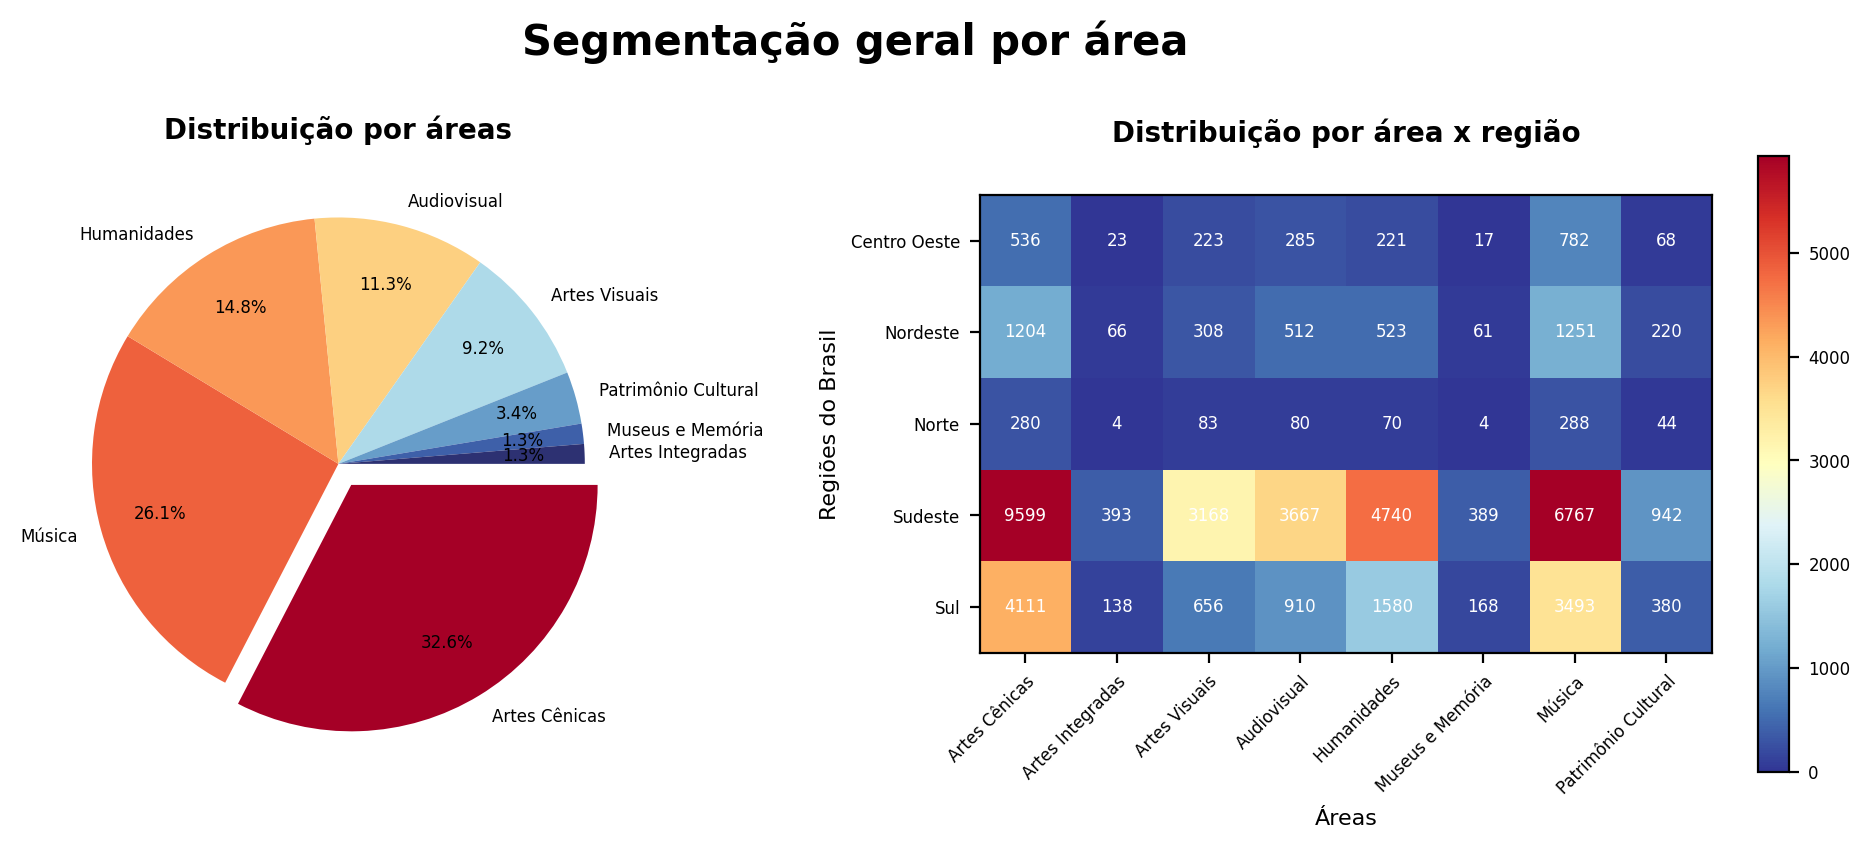

In [32]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#2D3172"]
separacao_fatia = (0.1, 0, 0, 0, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4), dpi=200)

ax1.pie(
    distribuicao_areas_brasil.values.flatten(), 
    labels=distribuicao_areas_brasil.index, 
    autopct="%1.1f%%", 
    pctdistance=0.75,
    counterclock=False,
    colors=cores, 
    explode=separacao_fatia
)

heatmap = ax2.imshow(
    areas_por_regiao.values,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=media_sudeste
)

plt.setp(
    ax2.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)

plt.colorbar(heatmap, ax=ax2)

for i in range(len(areas_por_regiao.index)):
    for j in range(len(areas_por_regiao.columns)):
        texto = ax2.text(
            j, i,
            areas_por_regiao.iloc[i, j],
            ha="center",
            va="center",
            color="#FFF"
        )

pos = ax2.get_position()
ax2.set_position([pos.x0, pos.y0 + 0.05, pos.width, pos.height])

ax2.set_xticks(np.arange(len(areas_por_regiao.columns)), labels=areas_por_regiao.columns)
ax2.set_yticks(np.arange(len(areas_por_regiao.index)), labels=areas_por_regiao.index)

ax2.set_xlabel("Áreas", fontsize=8)
ax2.set_ylabel("Regiões do Brasil", fontsize=8)

fig.suptitle("Segmentação geral por área", fontsize=15, fontweight=1000, y=1.05)
ax1.set_title("Distribuição por áreas", fontsize=10, fontweight=600)
ax2.set_title("Distribuição por área x região", fontsize=10, fontweight=600, y=1.08)

plt.savefig(path.abspath("charts/projetos_por_area01.png"), bbox_inches="tight")
plt.show()

In [33]:
ufs_sul_sudeste = df_projetos.groupby("regiao")["UF"].value_counts().sort_index()[["Sul", "Sudeste"]].index.get_level_values(1)
filtro_uf_sul_sudeste = df_projetos["UF"].str.contains("|".join(ufs_sul_sudeste))
projetos_sul_sudeste = df_projetos[filtro_uf_sul_sudeste]
areas_no_sul_sudeste = projetos_sul_sudeste.groupby("area")["UF"].value_counts().rename("qtd_projetos")
areas_no_sul_sudeste = areas_no_sul_sudeste.to_frame().unstack(level="area", fill_value=0)["qtd_projetos"]

filtro_uf_sp = df_projetos["UF"] == "SP"
qtd_projetos_por_cidade_sp = df_projetos[filtro_uf_sp]["municipio"].value_counts().rename("qtd_projetos").sort_index()
mapa_sp = geobr.read_municipality("SP").sort_values(by="name_muni")
mapa_sp_qtd_projetos_por_cidade = pd.Series(np.zeros(len(mapa_sp))).rename("qtd_projetos")

# corrigindo nomes errados no mapa baixado
mapa_sp.loc[mapa_sp["name_muni"] == "Moji Mirim", "name_muni"] = "Mogi Mirim"
mapa_sp.loc[mapa_sp["name_muni"] == "Embu", "name_muni"] = "Embu Das Artes"
mapa_sp.loc[mapa_sp["name_muni"] == "Santa Bárbara D'oeste", "name_muni"] = "Santa Bárbara D'Oeste"
mapa_sp.loc[mapa_sp["name_muni"] == "São Luís Do Paraitinga", "name_muni"] = "São Luiz Do Paraitinga"
mapa_sp.loc[mapa_sp["name_muni"] == "Aparecida D'oeste", "name_muni"] = "Aparecida D'Oeste"

filtro_cidades_sp_com_projetos = mapa_sp["name_muni"].str.title().apply(lambda cidade: cidade in qtd_projetos_por_cidade_sp.index)
filtro_indices_cidades_sp_com_projetos = mapa_sp["name_muni"][filtro_cidades_sp_com_projetos].index
mapa_sp_qtd_projetos_por_cidade[filtro_indices_cidades_sp_com_projetos] = qtd_projetos_por_cidade_sp.values

if "qtd_projetos" not in mapa_sp.columns:
    mapa_sp = pd.concat([mapa_sp, mapa_sp_qtd_projetos_por_cidade], axis=1)

media_sp = areas_no_sul_sudeste.sum(axis=1)["SP"] / len(areas_no_sul_sudeste.index)

display(areas_no_sul_sudeste, mapa_sp.head(10))

area,Artes Cênicas,Artes Integradas,Artes Visuais,Audiovisual,Humanidades,Museus e Memória,Música,Patrimônio Cultural
UF,,,,,,,,
ES,197,1,29,123,73,7,153,40
MG,1663,97,368,685,961,87,1860,321
PR,1410,42,244,354,492,61,1091,119
RJ,2964,109,801,1040,1122,118,1604,249
RS,1765,68,237,272,671,60,1486,161
SC,936,28,175,284,417,47,916,100
SP,4775,186,1970,1819,2584,177,3150,332


,code_muni,name_muni,code_state,abbrev_state,geometry,qtd_projetos
0,3500105.0,Adamantina,35.0,SP,"POLYGON ((-51.09093 -21.47214, -51.08788 -21.4...",10.0
1,3500204.0,Adolfo,35.0,SP,"POLYGON ((-49.69668 -21.34430, -49.69703 -21.3...",0.0
2,3500303.0,Aguaí,35.0,SP,"POLYGON ((-47.01254 -22.00527, -47.01076 -22.0...",1.0
7,3500709.0,Agudos,35.0,SP,"POLYGON ((-49.01670 -22.38629, -49.00953 -22.3...",1.0
8,3500758.0,Alambari,35.0,SP,"POLYGON ((-47.86567 -23.51306, -47.86243 -23.5...",0.0
9,3500808.0,Alfredo Marcondes,35.0,SP,"POLYGON ((-51.37102 -21.87702, -51.36865 -21.8...",0.0
10,3500907.0,Altair,35.0,SP,"POLYGON ((-49.14974 -20.57783, -49.15350 -20.5...",0.0
11,3501004.0,Altinópolis,35.0,SP,"POLYGON ((-47.43941 -20.93905, -47.43760 -20.9...",1.0
12,3501103.0,Alto Alegre,35.0,SP,"POLYGON ((-50.12430 -21.55169, -50.11314 -21.5...",0.0
13,3501152.0,Alumínio,35.0,SP,"POLYGON ((-47.26216 -23.56924, -47.26757 -23.5...",3.0


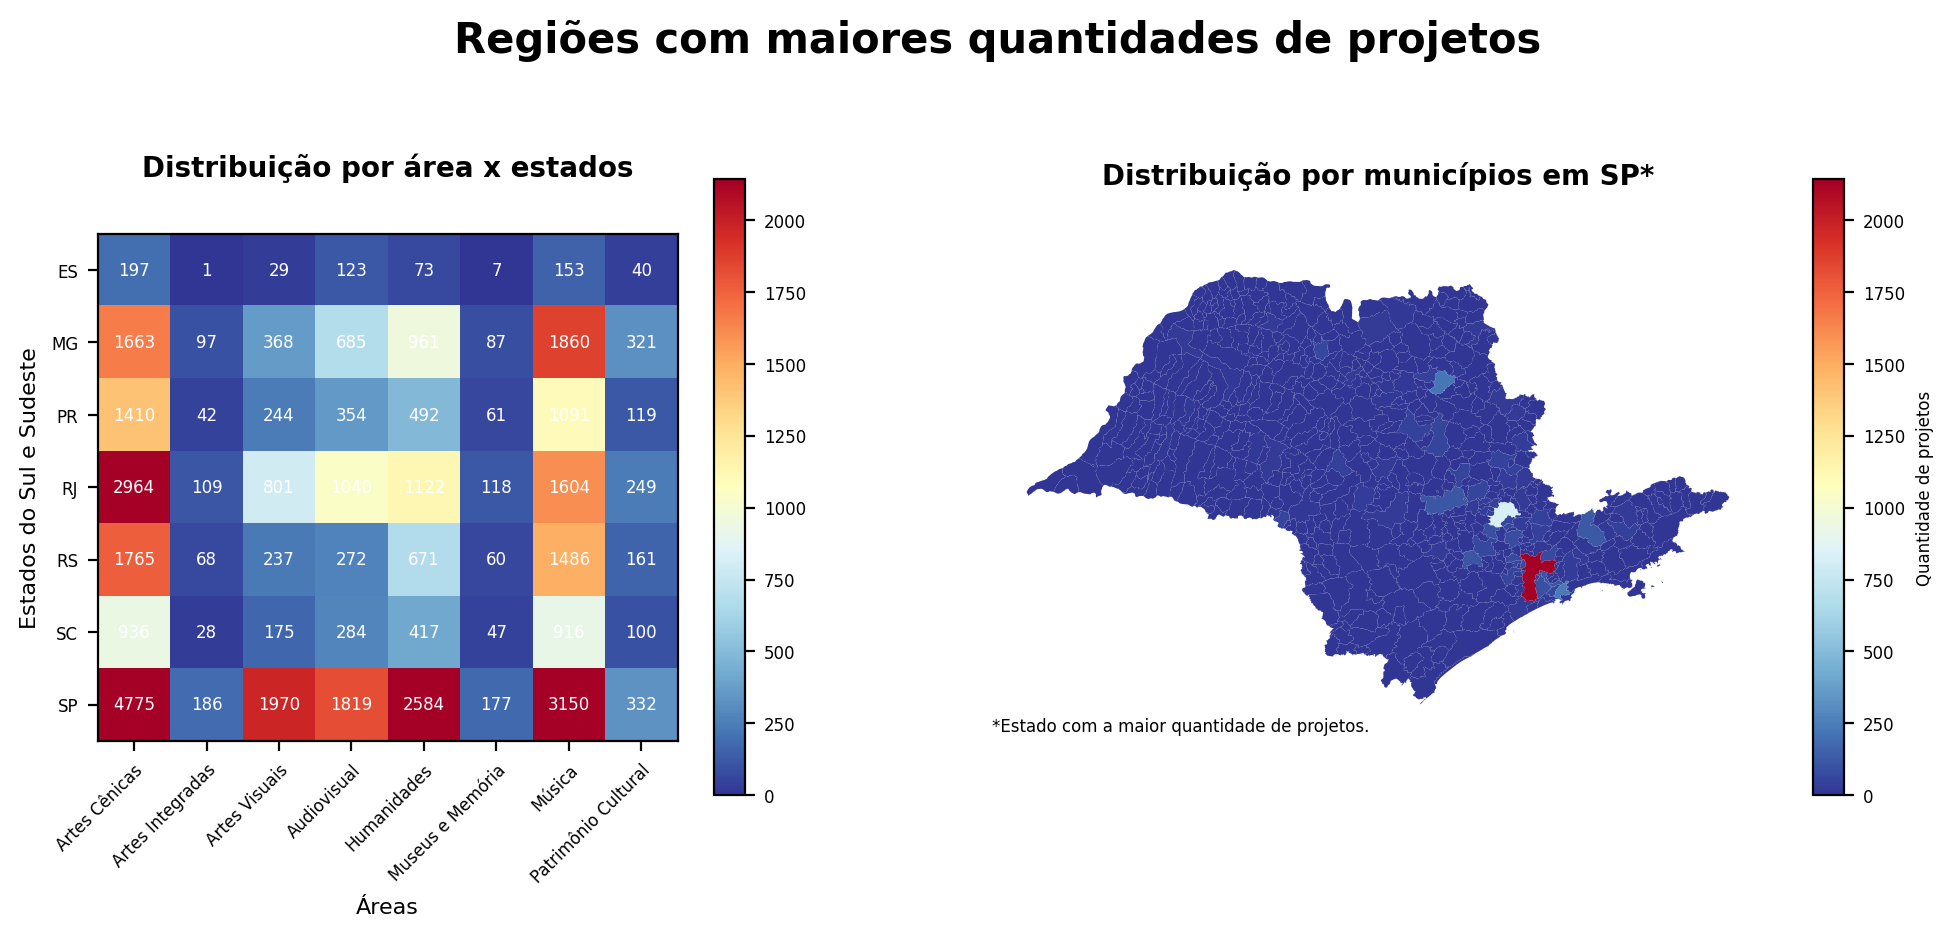

In [34]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#2D3172"]
separacao_fatia = (0.1, 0, 0, 0, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=200, gridspec_kw={"width_ratios": [3, 4]})

heatmap = ax1.imshow(
    areas_no_sul_sudeste.values,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=media_sp
)

plt.setp(
    ax1.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)

plt.colorbar(heatmap, ax=ax1)

for i in range(len(areas_no_sul_sudeste.index)):
    for j in range(len(areas_no_sul_sudeste.columns)):
        texto = ax1.text(
            j, i,
            areas_no_sul_sudeste.iloc[i, j],
            ha="center",
            va="center",
            color="#fff"
        )

mapa_sp.plot(
    column="qtd_projetos",
    cmap="RdYlBu_r",
    legend=True,
    legend_kwds={
        "label": "Quantidade de projetos",
        "orientation": "vertical",
    },
    ax=ax2,
    vmax=media_sp
)

ax2.axis("off")

ax1.set_xticks(np.arange(len(areas_no_sul_sudeste.columns)), labels=areas_no_sul_sudeste.columns)
ax1.set_yticks(np.arange(len(areas_no_sul_sudeste.index)), labels=areas_no_sul_sudeste.index)

ax1.set_xlabel("Áreas", fontsize=8)
ax1.set_ylabel("Estados do Sul e Sudeste", fontsize=8)

fig.suptitle("Regiões com maiores quantidades de projetos", fontsize=15, fontweight=1000, y=1.08)
ax1.set_title("Distribuição por área x estados", fontsize=10, fontweight=600, y=1.08)
ax2.set_title("Distribuição por municípios em SP*", fontsize=10, fontweight=600, y=1.1)

ax2.annotate(
    "*Estado com a maior quantidade de projetos.",
    xy = (0, 0),
    xycoords="axes fraction",
    ha="left",
    va="center",
)

plt.savefig(path.abspath("charts/projetos_por_area02.png"), bbox_inches="tight")
plt.show()

#####

#### Verificação da distribuição dos projetos em relação às áreas ao longo dos anos

In [35]:
areas_por_anos = df_projetos.groupby("area")["ano_projeto"].value_counts(sort=False).rename("qtd_projetos")
areas_por_anos = areas_por_anos.to_frame().unstack(level="area", fill_value=0)["qtd_projetos"]

ordenacao = areas_por_anos.values.sum(axis=0).argsort()

indices = areas_por_anos.index
colunas = areas_por_anos.columns.T[ordenacao[::-1]].T
valores = areas_por_anos.values.T[ordenacao[::-1]].T
areas_por_anos = pd.DataFrame(valores, index=indices, columns=colunas)

medias = areas_por_anos.values.mean(axis=0)

display(areas_por_anos)

area,Artes Cênicas,Música,Humanidades,Audiovisual,Artes Visuais,Patrimônio Cultural,Museus e Memória,Artes Integradas
ano_projeto,,,,,,,,
2009,345,293,246,147,73,43,0,255
2010,482,516,365,220,134,80,0,183
2011,533,494,320,266,153,69,0,186
2012,602,495,294,208,172,71,0,0
2013,690,507,385,458,204,62,0,0
2014,697,498,328,481,180,67,0,0
2015,758,507,309,427,189,53,0,0
2016,831,613,342,275,170,98,1,0
2017,1559,1127,562,262,345,150,23,0


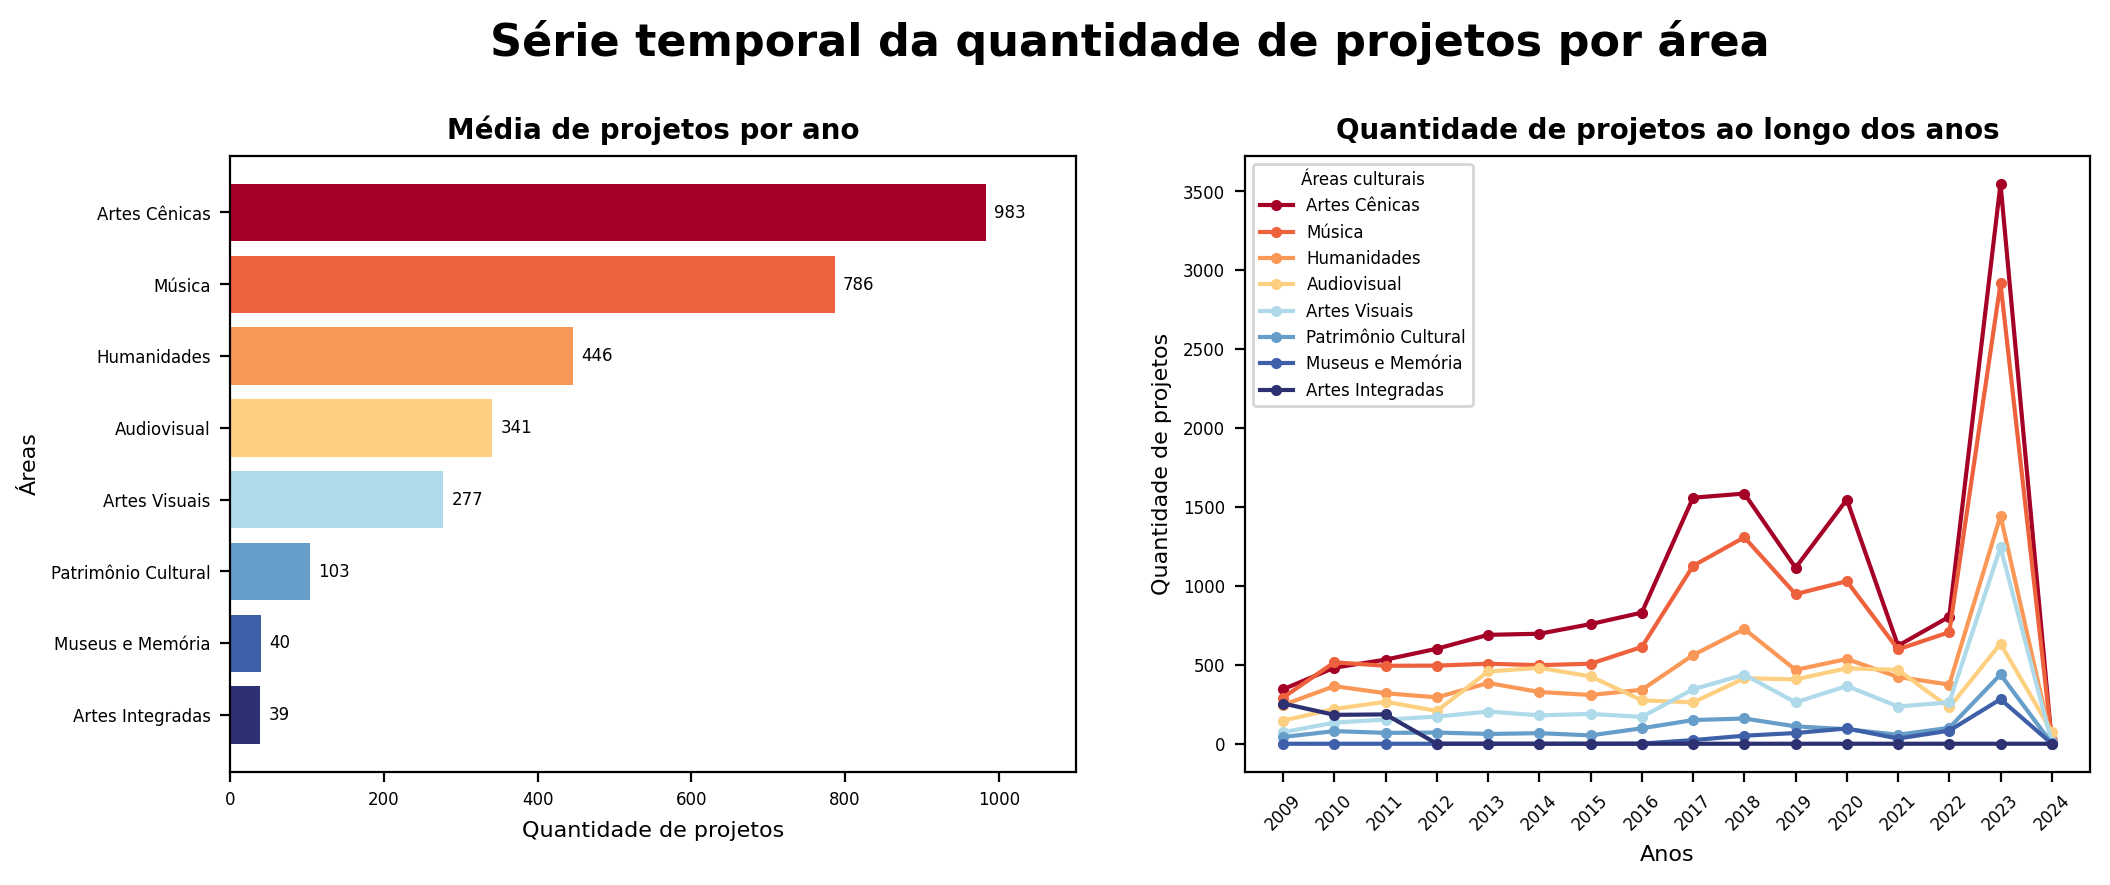

In [36]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#2D3172"]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=200)

barras = ax1.barh(
    areas_por_anos.columns,
    medias,
    color=cores,
)

for barra in barras:
    comprimento = barra.get_width()
    ax1.annotate(
        text=f'{round(comprimento)}',
        xy=(comprimento, barra.get_y() + barra.get_height() / 2),
        xytext=(3, 0),
        textcoords="offset points",
        va="center"
    )

ax1.invert_yaxis()

for i, qtd_projetos in enumerate(areas_por_anos.T.values):
    ax2.plot(
        areas_por_anos.index,
        qtd_projetos,
        label=areas_por_anos.columns[i],
        color=cores[i],
        marker="o",
        markersize=3
    )

ax2.set_xticks(areas_por_anos.index)
ax2.set_xticklabels(areas_por_anos.index, rotation=45)

ax1.set_xlabel("Quantidade de projetos", fontsize=8)
ax1.set_ylabel("Áreas", fontsize=8)

ax2.set_xlabel("Anos", fontsize=8)
ax2.set_ylabel("Quantidade de projetos", fontsize=8)

ax2.legend(title="Áreas culturais")

plt.suptitle("Série temporal da quantidade de projetos por área", fontsize=16, fontweight=1000, y=1.05)
ax1.set_title("Média de projetos por ano", fontsize=10, fontweight=600)
ax2.set_title("Quantidade de projetos ao longo dos anos", fontsize=10, fontweight=600)

ax1.set_xlim(0, 1100)

plt.savefig(path.abspath("charts/projetos_por_area03.png"), bbox_inches="tight")
plt.show()

#####

#### Análise do tempo necessário para iniciar um projeto e duração média por área

In [37]:
tempo_ate_iniciar_por_area = df_projetos.groupby("area")["tempo_para_iniciar"].mean().to_frame()
duracao_por_area = df_projetos.groupby("area")["duracao"].mean().to_frame()

display(tempo_ate_iniciar_por_area, duracao_por_area)

,tempo_para_iniciar
area,
Artes Cênicas,191.866545
Artes Integradas,233.549279
Artes Visuais,220.483269
Audiovisual,279.328520
Humanidades,170.593356
Museus e Memória,238.927230
Música,189.636197
Patrimônio Cultural,232.973851


,duracao
area,
Artes Cênicas,660.988557
Artes Integradas,445.894231
Artes Visuais,646.730735
Audiovisual,559.307481
Humanidades,705.547659
Museus e Memória,692.223787
Música,650.628090
Patrimônio Cultural,821.889964


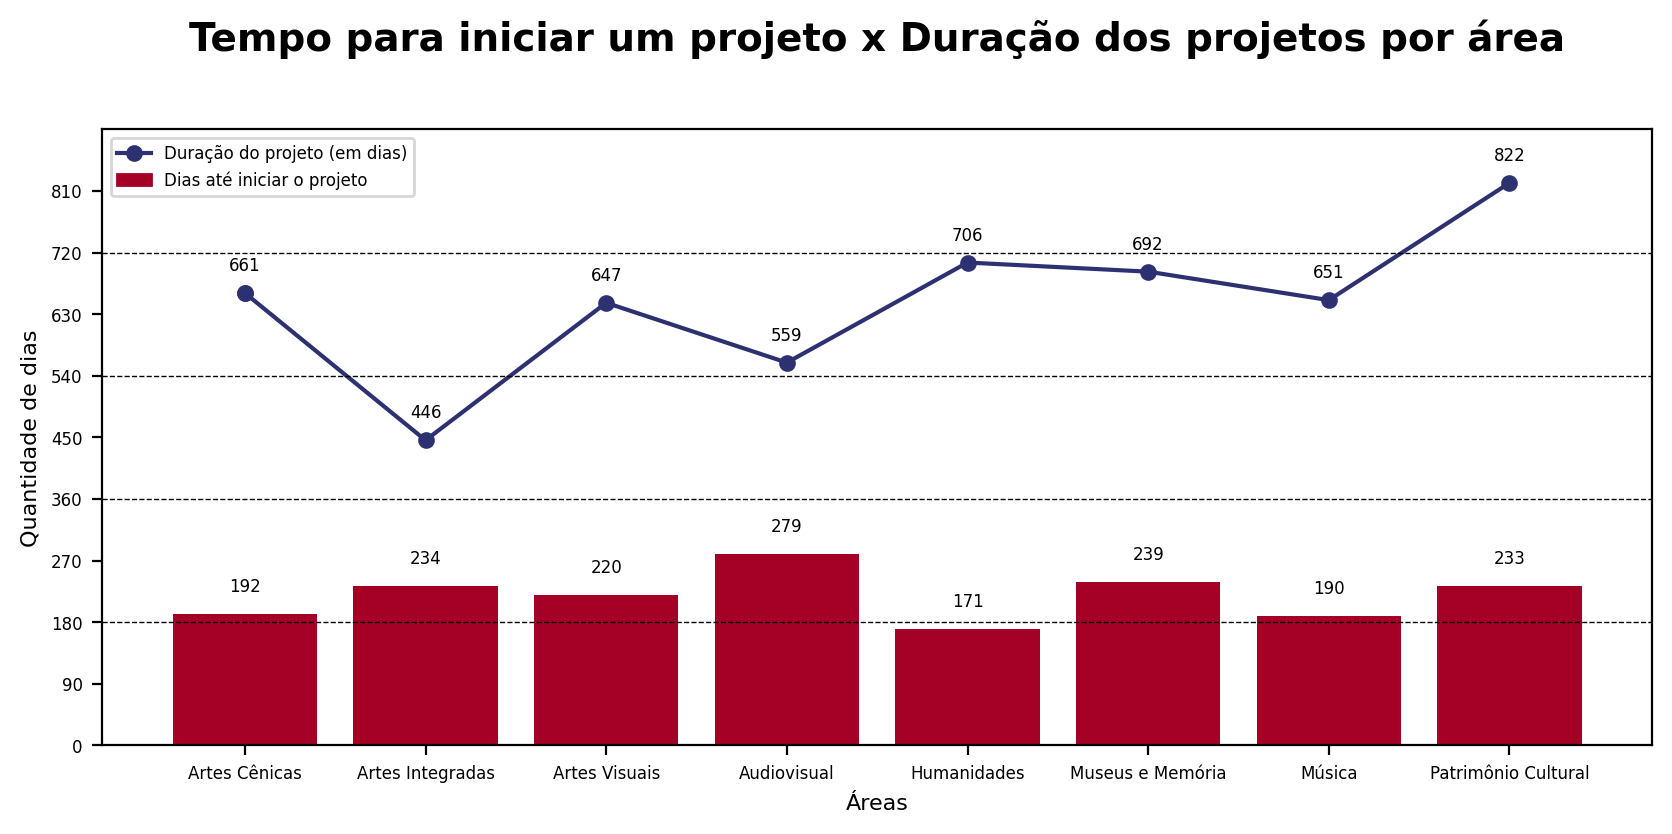

In [38]:
plt.rcParams.update({"font.size": 6})

figure, axs = plt.subplots(figsize=(10, 4), dpi=200)


def rotulos(arr):
    for x, y in zip(arr.index, arr.values.flatten()):
        axs.annotate(
            f"{round(y)}",
            (x, y),
            textcoords="offset points",
            xytext=(0, 8),
            ha="center"
        )


axs.bar(
    tempo_ate_iniciar_por_area.index,
    tempo_ate_iniciar_por_area.values.flatten(),
    color="#A50026"
)

axs.plot(
    duracao_por_area.index,
    duracao_por_area.values.flatten(),
    marker="o",
    markersize=5,
    color="#2D3172"
)

plt.ylim(0, 900)

altura_eixo_y = round(axs.get_ylim()[-1])
for i in range(180, altura_eixo_y, 180):
    plt.axhline(y=i, color="#000", linewidth=0.5, linestyle="dashed")

proxy_barras = plt.Rectangle(
    (0, 0), 1, 1, 
    color="#A50026", 
    label="Dias até iniciar o projeto"
)

proxy_linha, = plt.plot(
    0, duracao_por_area.values.flatten()[0], 
    marker="o", 
    markersize=5, 
    color="#2D3172", 
    label="Duração do projeto (em dias)"
)

axs.legend(handles=[proxy_linha, proxy_barras])

rotulos(tempo_ate_iniciar_por_area)
rotulos(duracao_por_area)

plt.xlabel("Áreas", fontsize=8)
plt.ylabel("Quantidade de dias", fontsize=8)

plt.yticks(np.arange(0, duracao_por_area.values.flatten().max(), 90))

plt.title("Tempo para iniciar um projeto x Duração dos projetos por área", fontsize=14, fontweight=1000, y=1.1)

plt.savefig(path.abspath("charts/projetos_por_area04.png"), bbox_inches="tight")
plt.show()

#####

#### Exploração dos mecanismos de incentivo à cultura e enquadramentos dos projetos por área

**Sobre os mecanismos utilizados pela Lei Rouanet**

- Incentivo Fiscal (mecenato)

O incentivo é um mecanismo em que a União faculta às pessoas físicas ou jurídicas a opção pela aplicação de parcelas do Imposto sobre a Renda, a título de doações ou patrocínios, no apoio direto a projetos culturais aprovados pelo Ministério da Cultura. Ou seja: o Governo Federal oferece uma ferramenta para que a sociedade possa decidir aplicar parte do dinheiro de seus impostos em ações culturais. Desta maneira, o incentivo fiscal estimula a participação da iniciativa privada, do mercado empresarial e dos cidadãos no aporte de recursos para o campo da cultura, diversificando possibilidades de financiamento, ampliando o volume de recursos destinados ao setor, atribuindo a ele mais potência e mais estratégia econômica.

- Fundo Nacional da Cultura (FNC)

O Fundo Nacional da Cultura (FNC) representa o investimento direto do Estado no fomento à Cultura, já que o apoio a projetos decorre de recursos do orçamento da União dentre outras fontes, como 3% do valor bruto arrecado pelas loterias federais e doações. O apoio via FNC tem como objetivo promover a distribuição regional dos recursos de forma equilibrada e é voltado aos projetos com maior dificuldade de captação junto ao mercado.

**Sobre os enquadramentos dos projetos**

Projetos aprovados no Artigo 18 da Lei Rouanet podem ser patrocinados com 100% de isenção fiscal, tanto por pessoa jurídica quanto física, enquanto projetos aprovados no Artigo 26 da Lei Rouanet oferecem os seguintes limites de isenção fiscal:

Pessoa Jurídica

- 40% do valor incentivado, no caso de doação.
- 30% do valor incentivado, no caso de patrocínio.

Pessoa Física

- 80% do valor incentivado, no caso de doação.
- 60% do valor incentivado, no caso de patrocínio.

In [39]:
mecanismos = df_projetos["mecanismo"].value_counts().to_frame()

enquadramento_por_area = df_projetos.groupby("area")["enquadramento"].value_counts().rename("qtd_projetos")
enquadramento_por_area = enquadramento_por_area.to_frame().unstack(level="area")["qtd_projetos"]

ordenacao = enquadramento_por_area.sum(axis=0).argsort()

indices = enquadramento_por_area.index
colunas = enquadramento_por_area.columns[ordenacao][::-1]
valores = enquadramento_por_area.values.T[ordenacao][::-1].T
enquadramento_por_area = pd.DataFrame(valores, index=indices, columns=colunas)

display(mecanismos, enquadramento_por_area)

,count
mecanismo,
Mecenato,48254


area,Artes Cênicas,Música,Humanidades,Audiovisual,Artes Visuais,Patrimônio Cultural,Museus e Memória,Artes Integradas
enquadramento,,,,,,,,
Artigo 18,15729,9821,6747,4970,4317,1498,637,518
Artigo 26,1,2760,387,484,121,156,2,106


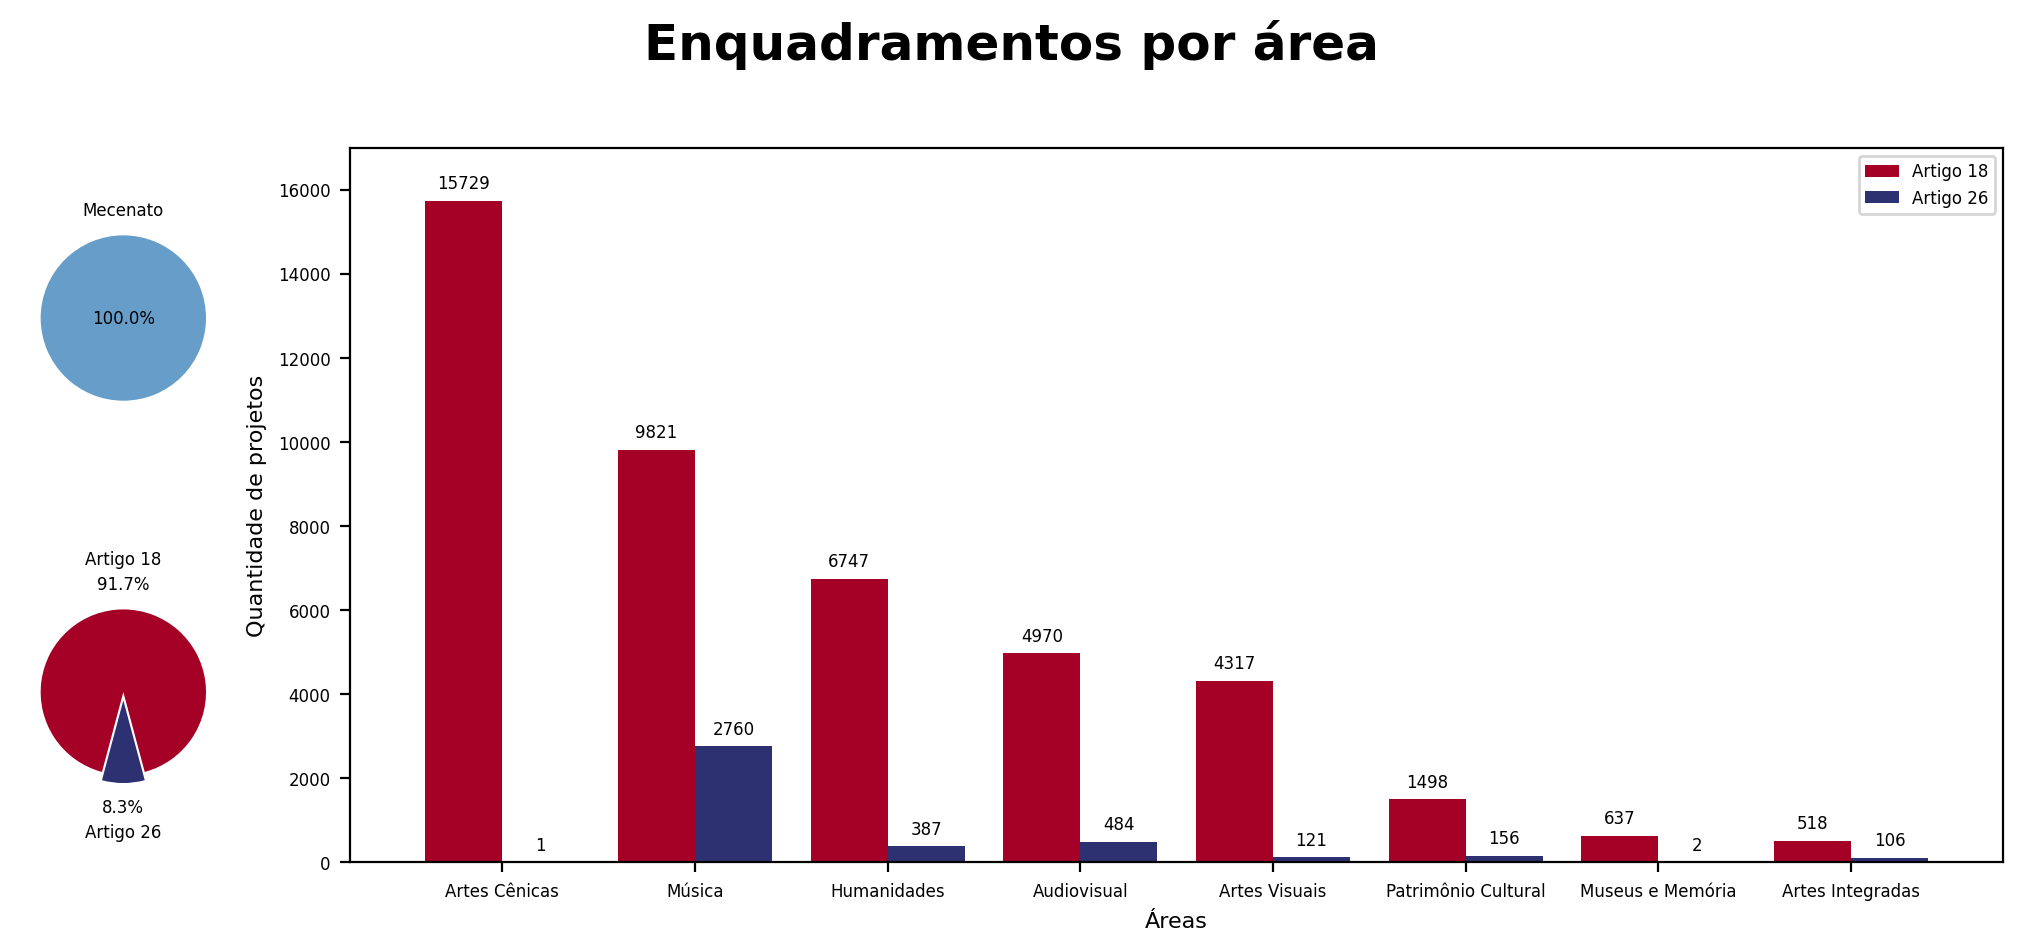

In [40]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#2D3172"]
separacao_fatia = (0, 0.1)

fig, axs = plt.subplot_mosaic([["1", "2"], ["3", "2"]], 
                              layout="constrained", 
                              figsize=(10, 4), 
                              dpi=200, 
                              gridspec_kw={"width_ratios": [1, 8]})


def rotulos(barras):
    for i, barra in enumerate(barras):
        altura = barra.get_height()
        ax2.annotate(
            text=f'{altura}',
            xy=(barra.get_x() + barra.get_width() / 2, altura),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom"
        )

ax1, ax2, ax3 = list(axs.values())

ax1.pie(
    mecanismos.values.flatten(),
    labels=mecanismos.index,
    labeldistance=1.3,
    autopct="%1.1f%%",
    pctdistance=0,
    startangle=-90,
    colors=[cores[5]],
    textprops={"ha": "center"}
)

eixo_x = np.arange(len(enquadramento_por_area.values.T))

barras1 = ax2.bar(
    eixo_x - 0.2,
    enquadramento_por_area.values[0],
    width=0.4, 
    color=cores[0],
    label="Artigo 18") 

barras2 = ax2.bar(
    eixo_x + 0.2,
    enquadramento_por_area.values[1],
    width=0.4, 
    color=cores[-1],
    label="Artigo 26") 

ax3.pie(
    enquadramento_por_area.values.sum(axis=1),
    labels=enquadramento_por_area.index,
    labeldistance=1.6,
    autopct="%1.1f%%",
    pctdistance=1.3,
    startangle=-75,    
    colors=[cores[0], cores[-1]],
    explode=separacao_fatia,
    textprops={"ha": "center"}
)

rotulos(barras1)
rotulos(barras2)

ax2.set_ylim(0, 17000)

ax2.set_xticks(np.arange(len(enquadramento_por_area.columns)), labels=enquadramento_por_area.columns)

ax2.set_xlabel("Áreas", fontsize=8)
ax2.set_ylabel("Quantidade de projetos", fontsize=8)

ax2.legend()

fig.suptitle("Enquadramentos por área", fontsize=18, fontweight=1000, y=1.15)

plt.savefig(path.abspath("charts/projetos_por_area05.png"), bbox_inches="tight")
plt.show()

####

### 4.2. Participação geográfica

#### Visualização da participação geográfica dos projetos

In [41]:
projetos_por_regiao = df_projetos["regiao"].value_counts().rename("qtd_projetos")
regioes = geobr.read_region() # Download do mapa do Brasil dividido por regiões
regioes = regioes.merge(projetos_por_regiao, how="left", left_on="name_region", right_on="regiao")

projetos_por_estados = df_projetos["UF"].value_counts().rename("qtd_projetos")
estados = geobr.read_country(year=2020)  # Download do mapa do Brasil dividido por estados
estados = estados.merge(projetos_por_estados, how="left", left_on="abbrev_state", right_on="UF")

display(regioes, estados)

,code_region,name_region,geometry,qtd_projetos
0,1.0,Norte,"MULTIPOLYGON (((-46.06095 -1.09470, -46.06666 ...",853
1,2.0,Nordeste,"MULTIPOLYGON (((-38.65134 -17.94651, -38.65296...",4145
2,3.0,Sudeste,"MULTIPOLYGON (((-29.30279 -20.51580, -29.30540...",29665
3,4.0,Sul,"MULTIPOLYGON (((-48.46837 -27.70455, -48.46768...",11436
4,5.0,Centro Oeste,"MULTIPOLYGON (((-50.51107 -12.86077, -50.50895...",2155


,code_state,abbrev_state,name_state,code_region,name_region,geometry,qtd_projetos
0,11.0,RO,Rondônia,1.0,Norte,"MULTIPOLYGON (((-65.38150 -10.42907, -65.37916...",74
1,12.0,AC,Acre,1.0,Norte,"MULTIPOLYGON (((-71.07772 -9.82774, -71.08554 ...",15
2,13.0,AM,Amazônas,1.0,Norte,"MULTIPOLYGON (((-69.83766 -3.68659, -69.71230 ...",197
3,14.0,RR,Roraima,1.0,Norte,"MULTIPOLYGON (((-63.96008 2.47313, -63.96041 2...",17
4,15.0,PA,Pará,1.0,Norte,"MULTIPOLYGON (((-51.43248 -0.47334, -51.42843 ...",432
5,16.0,AP,Amapá,1.0,Norte,"MULTIPOLYGON (((-53.27918 2.18599, -53.27655 2...",26
6,17.0,TO,Tocantins,1.0,Norte,"MULTIPOLYGON (((-48.23291 -5.94757, -48.23163 ...",92
7,21.0,MA,Maranhão,2.0,Nordeste,"MULTIPOLYGON (((-46.16128 -1.62285, -46.14936 ...",366
8,22.0,PI,Piauí,2.0,Nordeste,"MULTIPOLYGON (((-42.91509 -6.64795, -42.91727 ...",165
9,23.0,CE,Ceará,2.0,Nordeste,"MULTIPOLYGON (((-41.18292 -4.01797, -41.18862 ...",1022


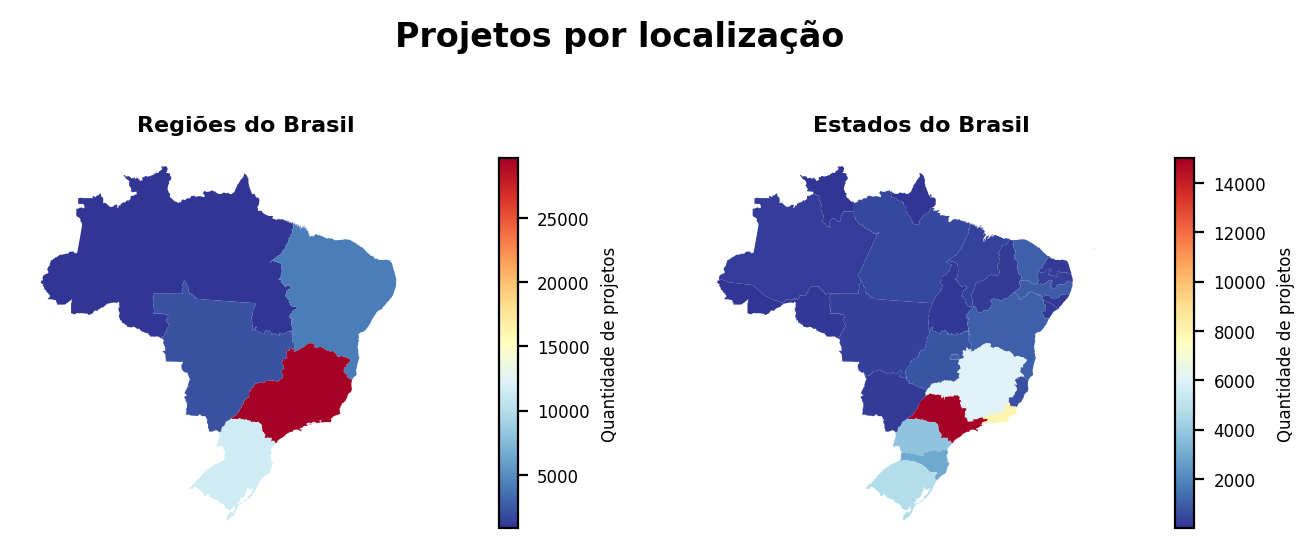

In [42]:
plt.rcParams.update({"font.size": 6})

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), dpi=200)


def plot_mapa(mapa, axis):
    mapa.plot(
        column="qtd_projetos",
        cmap="RdYlBu_r",
        legend=True,
        legend_kwds={
            "label": "Quantidade de projetos",
            "orientation": "vertical",
            "shrink": 0.6,
        },
        ax=axis,
    )

    axis.axis("off")


plot_mapa(regioes, ax1)
plot_mapa(estados, ax2)

fig.suptitle("Projetos por localização", fontsize=12, fontweight=1000, y=0.9)
ax1.set_title("Regiões do Brasil", fontsize=8, fontweight=600)
ax2.set_title("Estados do Brasil", fontsize=8, fontweight=600)

plt.savefig(path.abspath("charts/projetos_por_regiao01.png"), bbox_inches="tight")
plt.show()

#####

#### Verificação da distribuição dos projetos em relação aos estados e regiões ao longo dos anos

In [43]:
estados_por_ano = df_projetos.groupby("ano_projeto")["UF"].value_counts().rename("qtd_projetos")
estados_por_ano = estados_por_ano.to_frame().unstack(level="ano_projeto", fill_value=0)["qtd_projetos"]

regioes_por_ano = df_projetos.groupby("ano_projeto")["regiao"].value_counts().rename("qtd_projetos")
regioes_por_ano = regioes_por_ano.to_frame().unstack(level="ano_projeto", fill_value=0)["qtd_projetos"]

ordenacao = regioes_por_ano.sum(axis=1).argsort()[::-1]
indices = regioes_por_ano.index[ordenacao]
colunas = regioes_por_ano.columns
valores = regioes_por_ano.values[ordenacao]
regioes_por_ano = pd.DataFrame(valores, index=indices, columns=colunas)

media_sp = estados_por_ano.sum(axis=1)["SP"] / len(estados_por_ano.columns)

display(estados_por_ano, regioes_por_ano)

ano_projeto,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
UF,,,,,,,,,,,,,,,,
AC,0,1,1,0,0,1,1,1,1,2,0,1,1,1,4,0
AL,1,3,2,0,0,1,1,1,6,4,6,4,13,11,26,1
AM,2,1,2,8,3,6,7,5,16,30,28,8,12,7,62,0
AP,0,0,1,0,1,0,1,0,1,1,2,1,0,2,16,0
BA,22,36,45,36,59,55,38,39,81,72,58,90,51,44,294,10
CE,41,42,59,26,44,52,42,57,77,69,66,78,48,67,250,4
DF,41,40,33,25,42,31,47,31,74,114,56,96,68,51,229,4
ES,3,18,24,15,16,19,21,19,42,64,43,57,53,53,172,4
GO,9,21,22,18,26,27,16,26,47,64,68,102,41,55,195,4


ano_projeto,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
regiao,,,,,,,,,,,,,,,,
Sudeste,977,1339,1329,1188,1451,1396,1430,1440,2548,2964,1971,2539,1471,1478,6069,75
Sul,269,402,433,474,582,600,545,603,977,1094,888,920,556,662,2414,17
Nordeste,89,156,173,114,171,161,154,193,297,296,269,376,229,243,1193,31
Centro Oeste,59,71,72,47,83,71,84,71,140,222,153,244,140,138,552,8
Norte,8,12,14,19,19,23,30,23,66,108,98,68,40,42,282,1


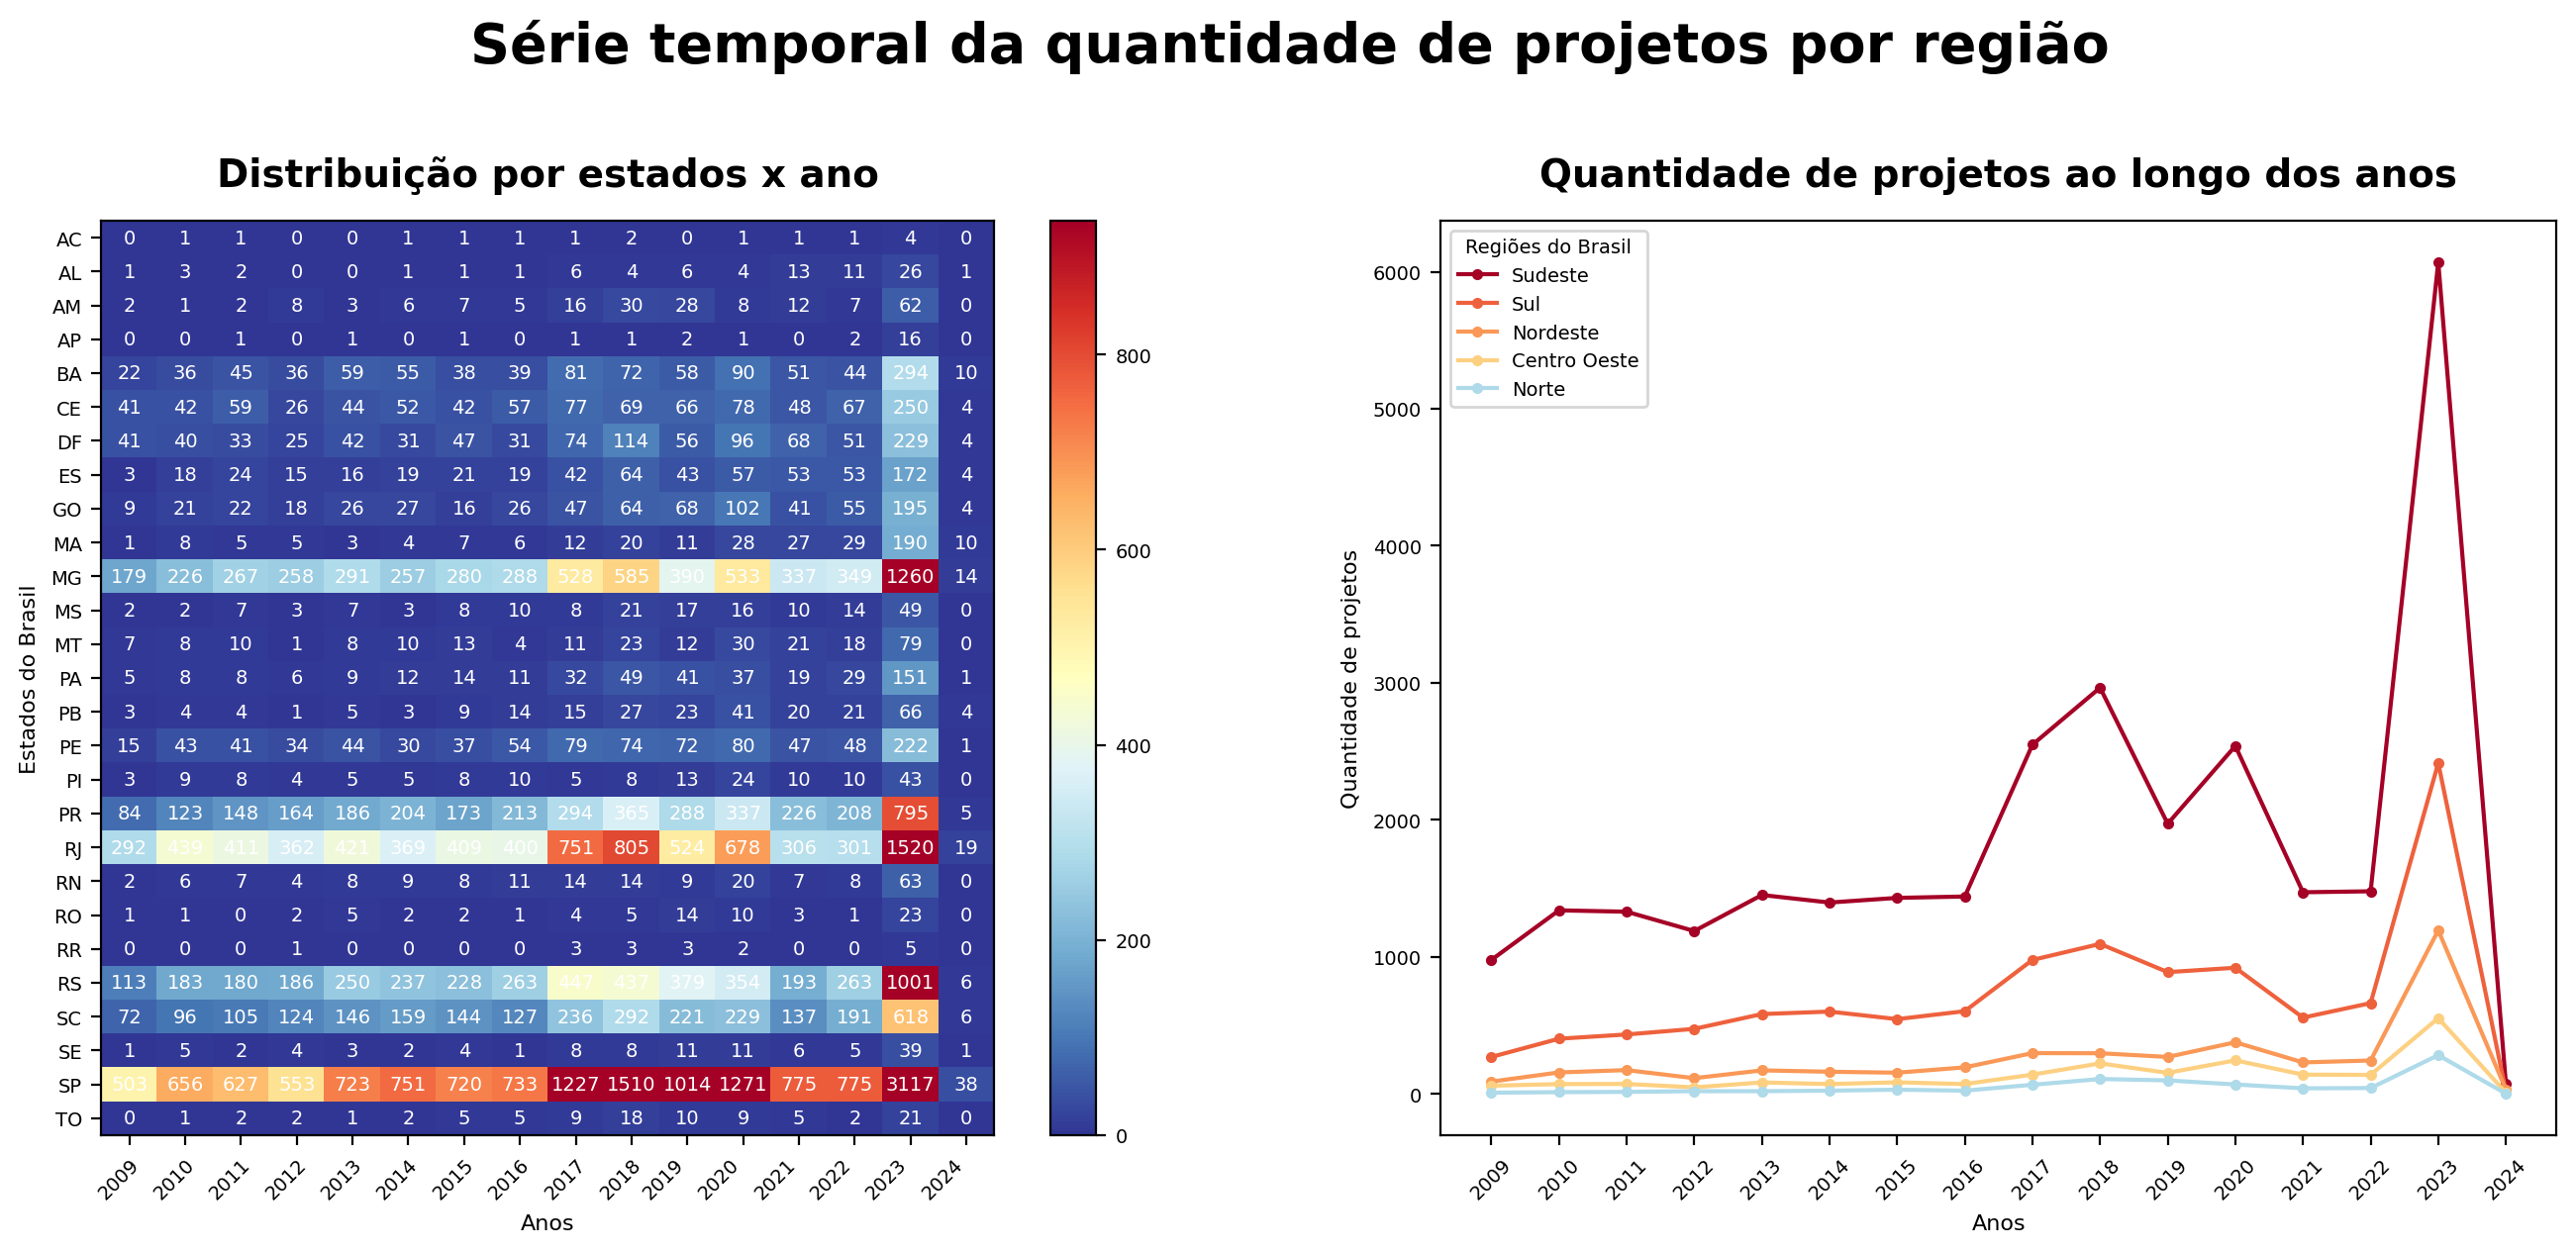

In [44]:
plt.rcParams.update({"font.size": 7})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#2D3172"]
separacao_fatia = (0.1, 0, 0, 0, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), dpi=200)

heatmap = ax1.imshow(
    estados_por_ano.values,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=media_sp
)

ax1.set_aspect(aspect="auto")

plt.setp(
    ax1.get_xticklabels(),
    rotation=45,
    ha="right",
    rotation_mode="anchor"
)

plt.colorbar(heatmap, ax=ax1)

for i, qtd_projetos in enumerate(regioes_por_ano.values):
    ax2.plot(
        regioes_por_ano.columns,
        qtd_projetos,
        label=regioes_por_ano.index[i],
        color=cores[i],
        marker="o",
        markersize=3
    )

for i in range(len(estados_por_ano.index)):
    for j in range(len(estados_por_ano.columns)):
        texto = ax1.text(
            j, i,
            estados_por_ano.iloc[i, j],
            ha="center",
            va="center",
            color="#FFF"
        )

ax1.set_xticks(np.arange(len(estados_por_ano.columns)), labels=estados_por_ano.columns)
ax1.set_yticks(np.arange(len(estados_por_ano.index)), labels=estados_por_ano.index)
ax2.set_xticks(regioes_por_ano.columns)
ax2.set_xticklabels(regioes_por_ano.columns, rotation=45)

ax1.set_xlabel("Anos", fontsize=8)
ax1.set_ylabel("Estados do Brasil", fontsize=8)
ax2.set_xlabel("Anos", fontsize=8)
ax2.set_ylabel("Quantidade de projetos", fontsize=8)

ax2.legend(title="Regiões do Brasil")

fig.suptitle("Série temporal da quantidade de projetos por região", fontsize=20, fontweight=1000, y=1.05)
ax1.set_title("Distribuição por estados x ano", fontsize=14, fontweight=600, y=1.02)
ax2.set_title("Quantidade de projetos ao longo dos anos", fontsize=14, fontweight=600, y=1.02)

plt.savefig(path.abspath("charts/projetos_por_regiao02.png"), bbox_inches="tight")
plt.show()

#####

#### Análise do tempo necessário para iniciar um projeto e duração média por região

In [45]:
tempo_ate_iniciar_por_estado = df_projetos.groupby("UF")["tempo_para_iniciar"].mean().to_frame()
duracao_por_estado = df_projetos.groupby("UF")["duracao"].mean().to_frame()

display(tempo_ate_iniciar_por_estado.T, duracao_por_estado.T)

UF,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
tempo_para_iniciar,194.8,164.3625,155.741117,224.769231,189.717233,192.989237,182.625,216.335875,220.825911,227.532787,...,193.114083,201.943518,199.926316,256.662162,85.941176,174.190201,196.150448,213.885135,217.814997,146.894022


UF,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
duracao,530.866667,567.9125,696.77665,638.769231,590.045631,578.534247,633.10998,628.033708,641.672065,486.877049,...,697.079465,637.843887,563.047368,605.72973,807.411765,648.343432,685.372718,591.063063,676.595878,697.945652


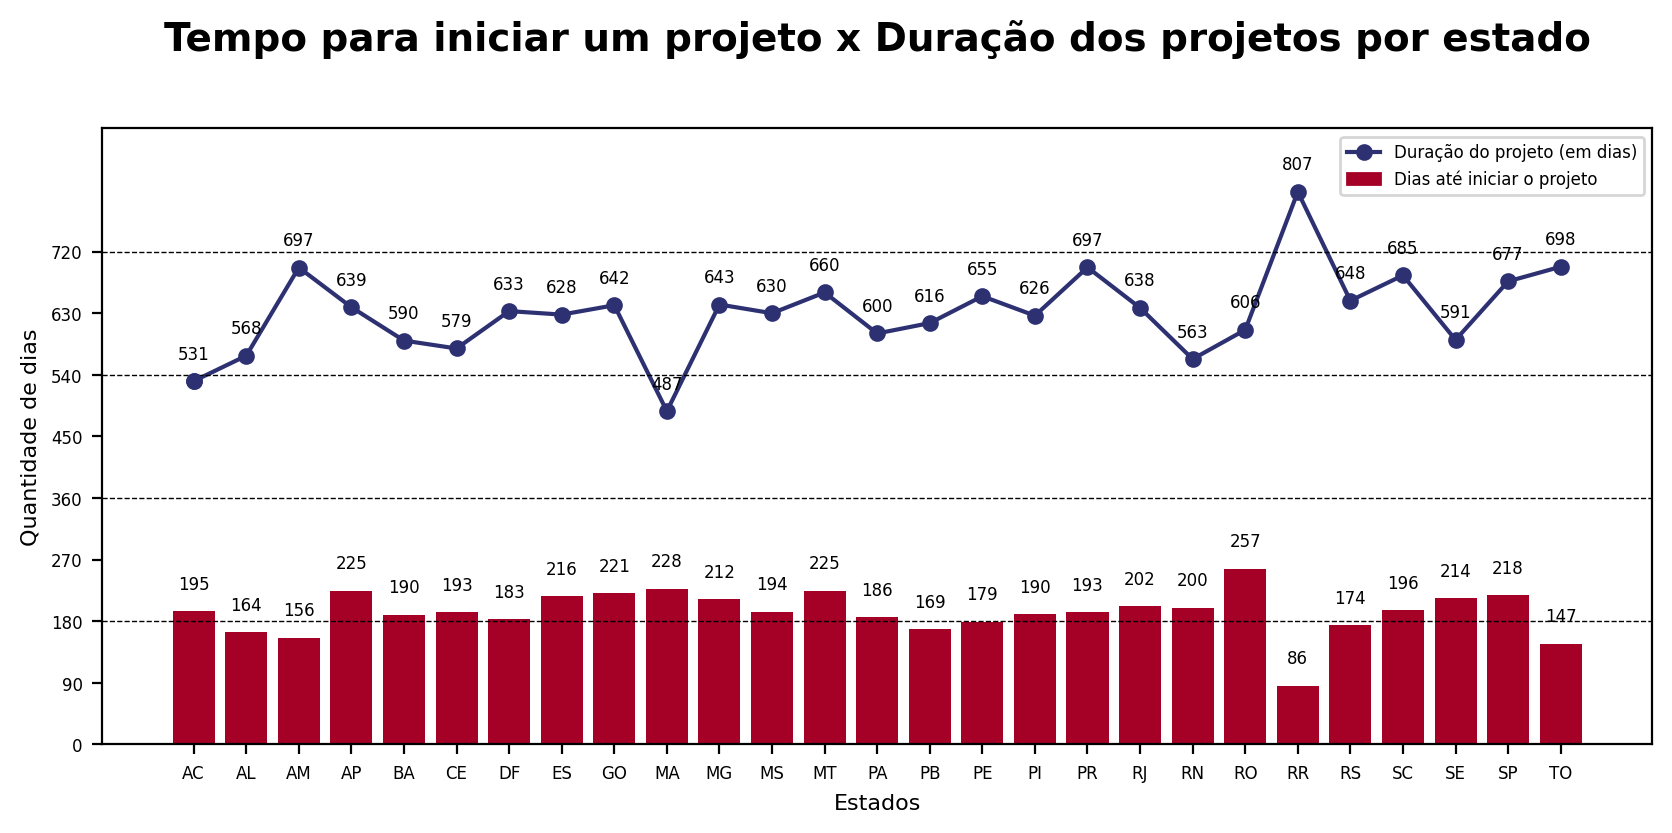

In [46]:
plt.rcParams.update({"font.size": 6})

figure, axs = plt.subplots(figsize=(10, 4), dpi=200)


def rotulos(arr):
    for x, y in zip(arr.index, arr.values.flatten()):
        axs.annotate(
            f"{round(y)}",
            (x, y),
            textcoords="offset points",
            xytext=(0, 8),
            ha="center"
        )


axs.bar(
    tempo_ate_iniciar_por_estado.index,
    tempo_ate_iniciar_por_estado.values.flatten(),
    color="#A50026"
)

axs.plot(
    duracao_por_estado.index,
    duracao_por_estado.values.flatten(),
    marker="o",
    markersize=5,
    color="#2D3172"
)

plt.ylim(0, 900)

altura_eixo_y = round(axs.get_ylim()[-1])
for i in range(180, altura_eixo_y, 180):
    plt.axhline(y=i, color="#000", linewidth=0.5, linestyle="dashed")

proxy_barras = plt.Rectangle(
    (0, 0), 1, 1, 
    color="#A50026", 
    label="Dias até iniciar o projeto"
)

proxy_linha, = plt.plot(
    0, duracao_por_estado.values.flatten()[0], 
    marker="o", 
    markersize=5, 
    color="#2D3172", 
    label="Duração do projeto (em dias)"
)

axs.legend(handles=[proxy_linha, proxy_barras])

rotulos(tempo_ate_iniciar_por_estado)
rotulos(duracao_por_estado)

plt.xlabel("Estados", fontsize=8)
plt.ylabel("Quantidade de dias", fontsize=8)

plt.yticks(np.arange(0, duracao_por_estado.values.flatten().max(), 90))

plt.title("Tempo para iniciar um projeto x Duração dos projetos por estado", fontsize=14, fontweight=1000, y=1.1)

plt.savefig(path.abspath("charts/projetos_por_regiao03.png"), bbox_inches="tight")
plt.show()

#####

#### Exploração dos mecanismos de incentivo à cultura e enquadramentos dos projetos por região

In [47]:
mecanismos = df_projetos["mecanismo"].value_counts().to_frame()

enquadramento_por_regiao = df_projetos.groupby("regiao")["enquadramento"].value_counts().rename("qtd_projetos")
enquadramento_por_regiao = enquadramento_por_regiao.to_frame().unstack(level="regiao")["qtd_projetos"]

ordenacao = enquadramento_por_regiao.sum(axis=0).argsort()

indices = enquadramento_por_regiao.index
colunas = enquadramento_por_regiao.columns[ordenacao][::-1]
valores = enquadramento_por_regiao.values.T[ordenacao][::-1].T
enquadramento_por_regiao = pd.DataFrame(valores, index=indices, columns=colunas)

display(mecanismos, enquadramento_por_regiao)

,count
mecanismo,
Mecenato,48254


regiao,Sudeste,Sul,Nordeste,Centro Oeste,Norte
enquadramento,,,,,
Artigo 18,27258,10825,3575,1851,728
Artigo 26,2407,611,570,304,125


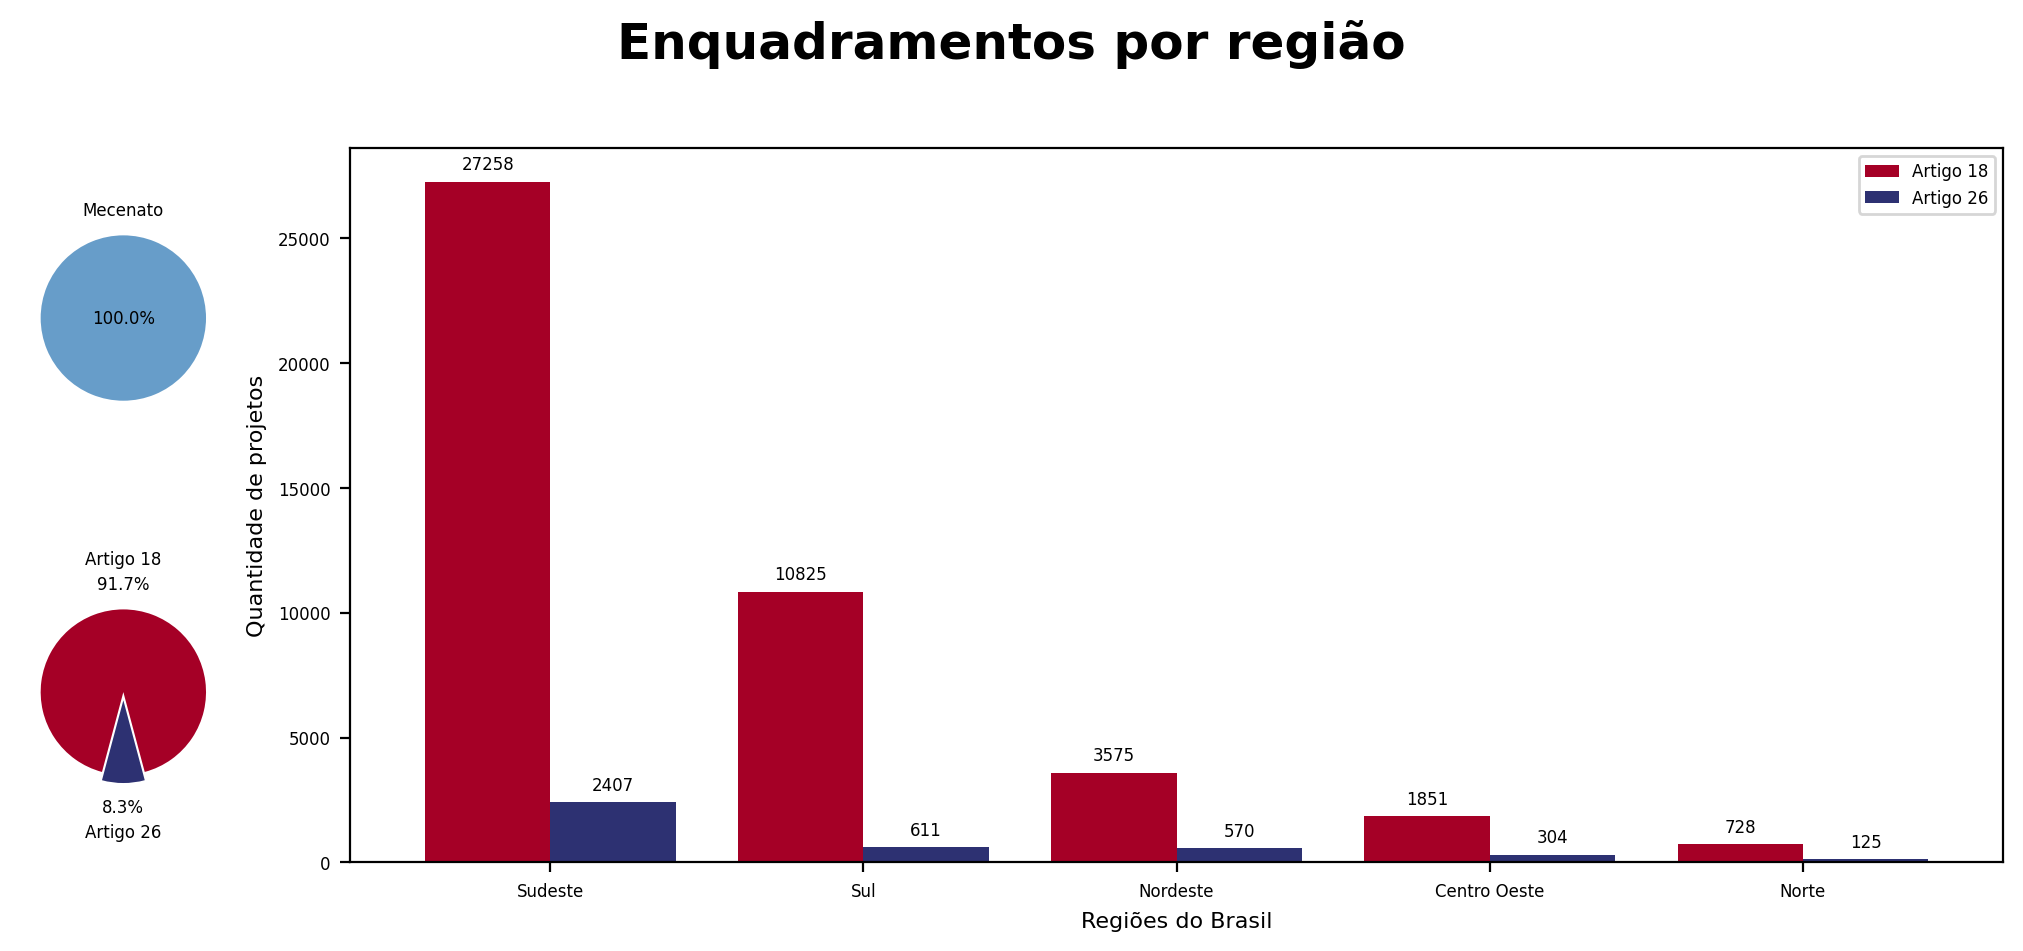

In [48]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#2D3172"]
separacao_fatia = (0, 0.1)

fig, axs = plt.subplot_mosaic([["1", "2"], ["3", "2"]], 
                              layout="constrained", 
                              figsize=(10, 4), 
                              dpi=200, 
                              gridspec_kw={"width_ratios": [1, 8]})


def rotulos(barras):
    for i, barra in enumerate(barras):
        altura = barra.get_height()
        ax2.annotate(
            text=f'{altura}',
            xy=(barra.get_x() + barra.get_width() / 2, altura),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom"
        )

ax1, ax2, ax3 = list(axs.values())

ax1.pie(
    mecanismos.values.flatten(),
    labels=mecanismos.index,
    labeldistance=1.3,
    autopct="%1.1f%%",
    pctdistance=0,
    startangle=-90,
    colors=[cores[5]],
    textprops={"ha": "center"}
)

eixo_x = np.arange(len(enquadramento_por_regiao.values.T))

barras1 = ax2.bar(
    eixo_x - 0.2,
    enquadramento_por_regiao.values[0],
    width=0.4, 
    color=cores[0],
    label="Artigo 18") 

barras2 = ax2.bar(
    eixo_x + 0.2,
    enquadramento_por_regiao.values[1],
    width=0.4, 
    color=cores[-1],
    label="Artigo 26") 

ax3.pie(
    enquadramento_por_regiao.values.sum(axis=1),
    labels=enquadramento_por_regiao.index,
    labeldistance=1.6,
    autopct="%1.1f%%",
    pctdistance=1.3,
    startangle=-75,    
    colors=[cores[0], cores[-1]],
    explode=separacao_fatia,
    textprops={"ha": "center"}
)

rotulos(barras1)
rotulos(barras2)

ax2.set_xticks(np.arange(len(enquadramento_por_regiao.columns)), labels=enquadramento_por_regiao.columns)

ax2.set_xlabel("Regiões do Brasil", fontsize=8)
ax2.set_ylabel("Quantidade de projetos", fontsize=8)

ax2.legend()

fig.suptitle("Enquadramentos por região", fontsize=18, fontweight=1000, y=1.15)

plt.savefig(path.abspath("charts/projetos_por_regiao04.png"), bbox_inches="tight")
plt.show()

####

### 4.3. Representividade sociocultural

#### Análise dos projetos voltados para as minorias

In [49]:
projetos_minorias = df_projetos["voltado_para_minorias"].value_counts().to_frame()
projetos_minorias = pd.DataFrame(projetos_minorias.values, index=["Geral", "Grupos minoritários"], columns=["qtd_projetos"])

projetos_por_ano_minorias = df_projetos.groupby("ano_projeto")["voltado_para_minorias"].value_counts().rename("qtd_projetos")
projetos_por_ano_minorias = projetos_por_ano_minorias.to_frame().unstack(level="ano_projeto")["qtd_projetos"]

display(projetos_minorias, projetos_por_ano_minorias)

,qtd_projetos
Geral,45959
Grupos minoritários,2295


ano_projeto,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
voltado_para_minorias,,,,,,,,,,,,,,,,
False,1362,1914,1958,1781,2225,2156,2157,2240,3833,4511,3232,3967,2295,2439,9771,118
True,40,66,63,61,81,95,86,90,195,173,147,180,141,124,739,14


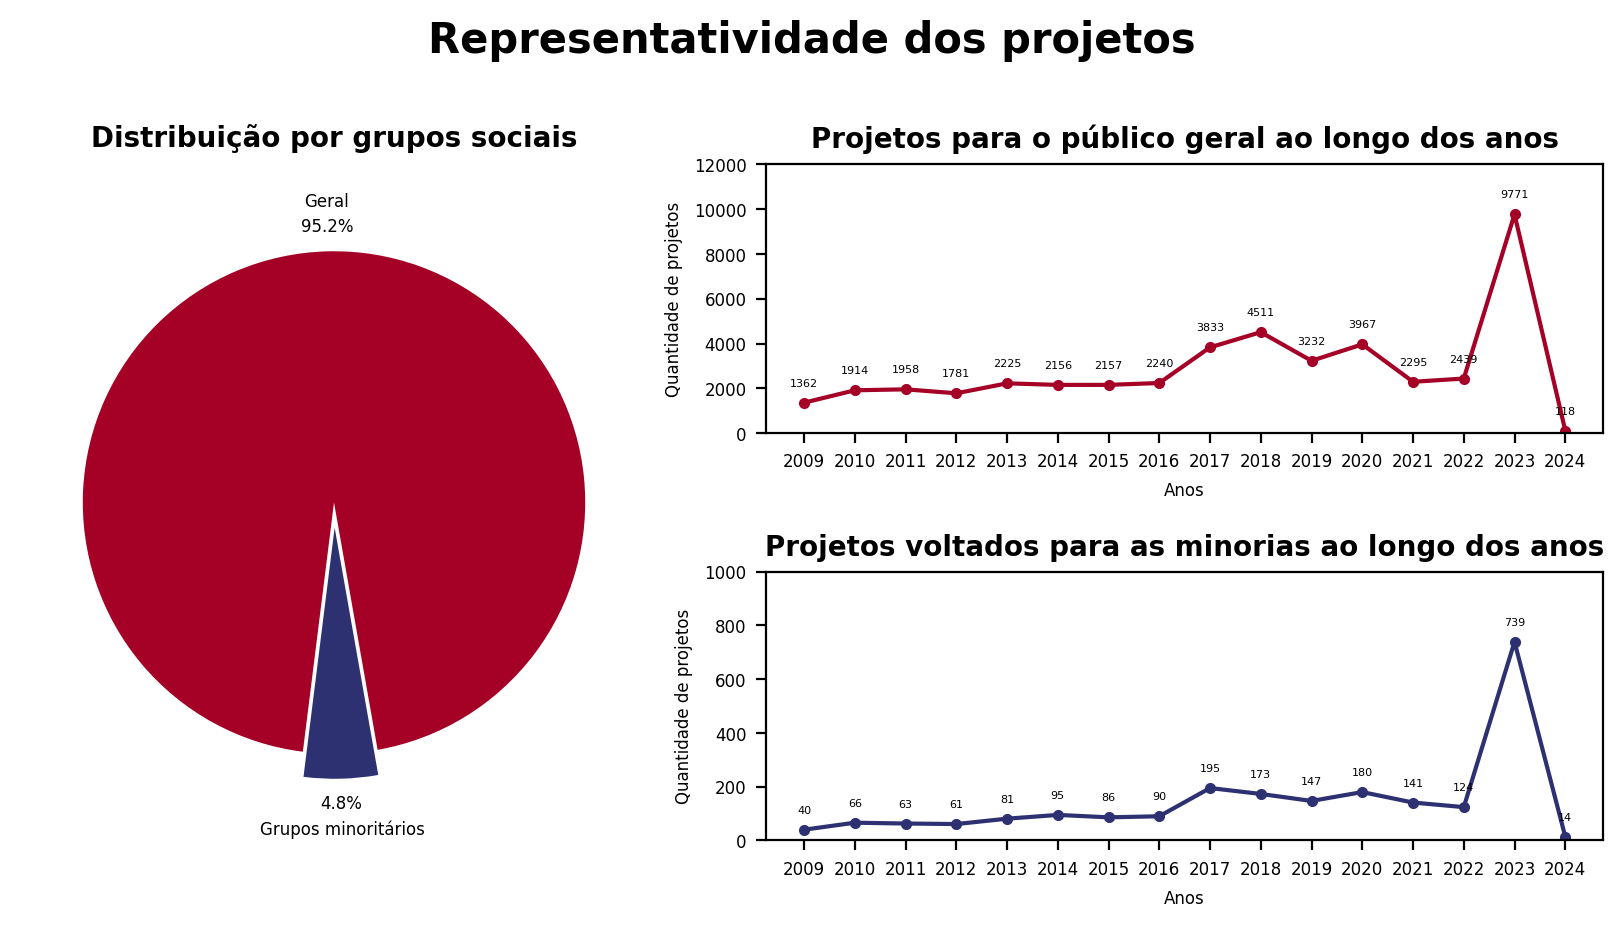

In [50]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#2D3172"]
separacao_fatia = (0, 0.1)

fig, axs = plt.subplot_mosaic([["1", "2"], ["1", "3"]], 
                              layout="constrained", 
                              figsize=(8, 4), 
                              dpi=200, 
                              gridspec_kw={"width_ratios": [3, 4]})

ax1, ax2, ax3 = list(axs.values())


def rotulos_pontos(arr_index, arr, ax):
    for x, y in zip(arr_index, arr):
        ax.annotate(
            f"{y}",
            (x, y),
            textcoords="offset points",
            xytext=(0, 6),
            fontsize=4,
            ha="center"
        )
        

ax1.pie(
    projetos_minorias.values.flatten(),
    labels=projetos_minorias.index,
    labeldistance=1.2,
    autopct="%1.1f%%",
    pctdistance=1.1,
    startangle=-80,    
    colors=[cores[0], cores[-1]],
    explode=separacao_fatia,
    textprops={"ha": "center"}
)
        

ax2.plot(
    projetos_por_ano_minorias.columns,
    projetos_por_ano_minorias.values[0],
    color=cores[0],
    marker='o',
    markersize=3
)

        
ax3.plot(
    projetos_por_ano_minorias.columns,
    projetos_por_ano_minorias.values[1],
    color=cores[-1],
    marker='o',
    markersize=3
)

rotulos_pontos(projetos_por_ano_minorias.columns, projetos_por_ano_minorias.values[0], ax2)
rotulos_pontos(projetos_por_ano_minorias.columns, projetos_por_ano_minorias.values[1], ax3)
        
ax2.set_ylim(0, 12000)
ax3.set_ylim(0, 1000)

ax2.set_xticks(projetos_por_ano_minorias.columns)
ax3.set_xticks(projetos_por_ano_minorias.columns)

ax2.set_xlabel("Anos")
ax2.set_ylabel("Quantidade de projetos")
ax3.set_xlabel("Anos")
ax3.set_ylabel("Quantidade de projetos")

plt.suptitle("Representatividade dos projetos", fontsize=15, fontweight=1000, y=1.12)
ax1.set_title("Distribuição por grupos sociais", fontsize=10, fontweight=600, y=1.04)
ax2.set_title("Projetos para o público geral ao longo dos anos", fontsize=10, fontweight=600)
ax3.set_title("Projetos voltados para as minorias ao longo dos anos", fontsize=10, fontweight=600)

plt.savefig(path.abspath("charts/projetos_por_representatividade01.png"), bbox_inches="tight")
plt.show()

#####

#### Avaliação da representatividade por área e por região geográfica

In [51]:
filtro_voltado_para_minorias_true = df_projetos["voltado_para_minorias"] == True
minorias_por_area = df_projetos[filtro_voltado_para_minorias_true]["area"].value_counts().sort_values(ascending=False)
minorias_por_regiao = df_projetos[filtro_voltado_para_minorias_true]["regiao"].value_counts().rename("qtd_projetos")

regioes = geobr.read_region()
regioes = regioes.merge(minorias_por_regiao, how="left", left_on="name_region", right_on="regiao")

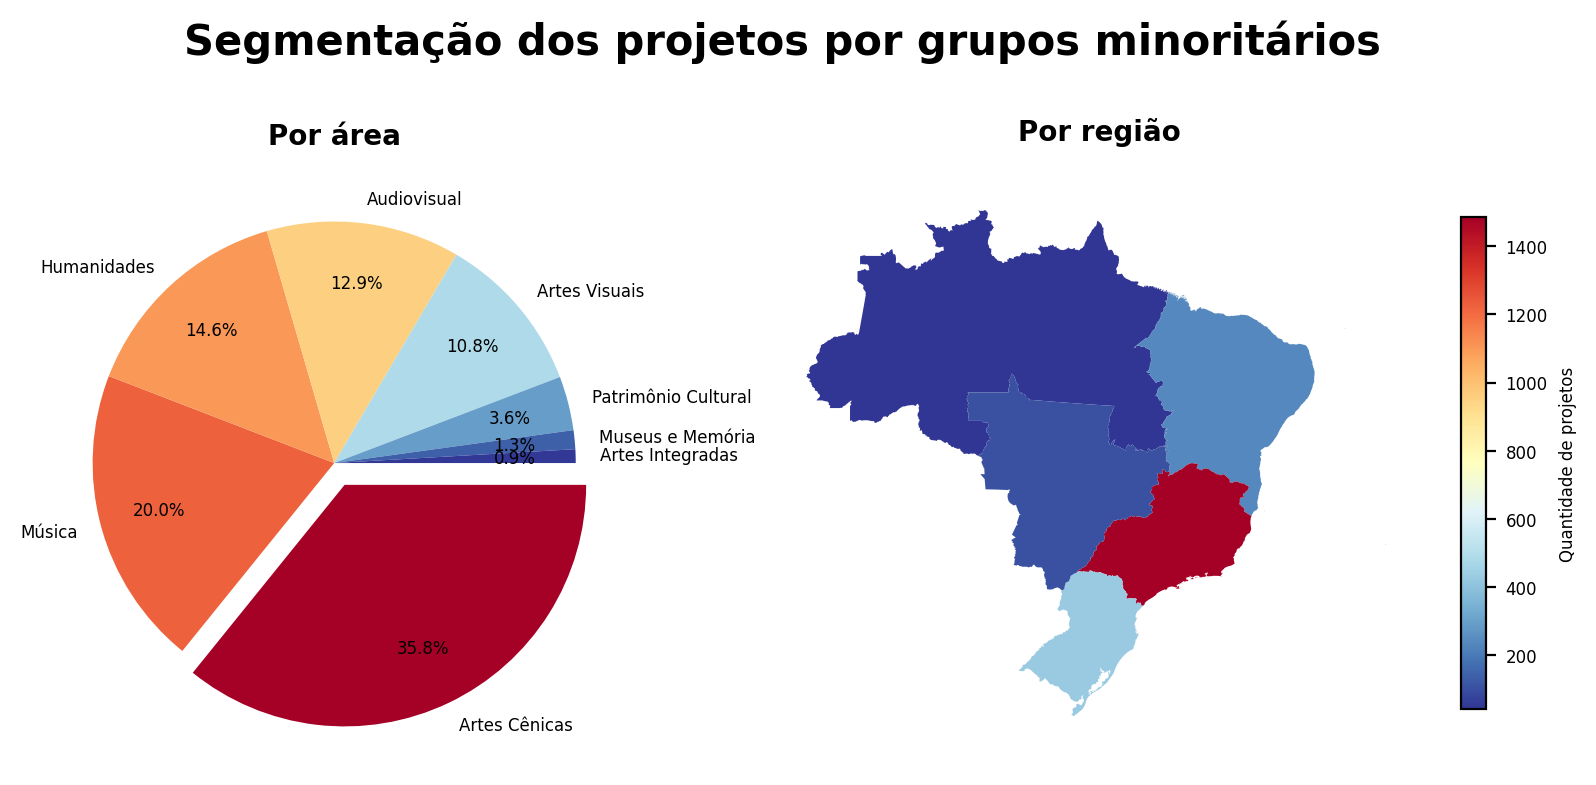

In [52]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#313896"]
separacao_fatia_area = (0.1, 0, 0, 0, 0, 0, 0, 0)
separacao_fatia_regiao = (0.1, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200, gridspec_kw={"width_ratios": [3, 4]})

ax1.pie(
    minorias_por_area,
    labels=minorias_por_area.index,
    autopct="%1.1f%%",
    pctdistance=0.75,
    counterclock=False,
    colors=cores,
    explode=separacao_fatia_area
)

regioes.plot(
        column="qtd_projetos",
        cmap="RdYlBu_r",
        legend=True,
        legend_kwds={
            "label": "Quantidade de projetos",
            "orientation": "vertical",
            "shrink": 0.8,
        },
        ax=ax2,
    )

ax2.axis("off")

fig.suptitle("Segmentação dos projetos por grupos minoritários", fontsize=15, fontweight=1000, y=1.05)
ax1.set_title("Por área", fontsize=10, fontweight=600)
ax2.set_title("Por região", fontsize=10, fontweight=600, y=1.05)

plt.savefig(path.abspath("charts/projetos_por_representatividade02.png"), bbox_inches="tight")
plt.show()

####

### 4.4. Distribuição de recursos

#### Análise da distribuição de recursos por área, estados, região, minoria e enquadramento

In [53]:
captacao_por_area = df_projetos.groupby("area")["valor_captado"].sum().rename("total")
captacao_por_area = captacao_por_area.to_frame().sort_values(by="total", ascending=False)
captacao_por_regiao = df_projetos.groupby("regiao")["valor_captado"].sum().rename("total")
captacao_por_regiao = captacao_por_regiao.to_frame().sort_values(by="total", ascending=False)

regioes = geobr.read_region()
regioes = regioes.merge(captacao_por_regiao, how="left", left_on="name_region", right_on="regiao")

display(captacao_por_area, captacao_por_regiao, regioes)

,total
area,
Artes Cênicas,5.785862e+09
Música,4.498651e+09
Artes Visuais,2.674364e+09
Patrimônio Cultural,2.304054e+09
Humanidades,1.483664e+09
Audiovisual,1.388066e+09
Museus e Memória,1.136425e+09
Artes Integradas,4.689919e+08


,total
regiao,
Sudeste,1.543542e+10
Sul,2.736030e+09
Nordeste,8.762023e+08
Centro Oeste,4.596036e+08
Norte,2.328256e+08


,code_region,name_region,geometry,total
0,1.0,Norte,"MULTIPOLYGON (((-46.06095 -1.09470, -46.06666 ...",2.328256e+08
1,2.0,Nordeste,"MULTIPOLYGON (((-38.65134 -17.94651, -38.65296...",8.762023e+08
2,3.0,Sudeste,"MULTIPOLYGON (((-29.30279 -20.51580, -29.30540...",1.543542e+10
3,4.0,Sul,"MULTIPOLYGON (((-48.46837 -27.70455, -48.46768...",2.736030e+09
4,5.0,Centro Oeste,"MULTIPOLYGON (((-50.51107 -12.86077, -50.50895...",4.596036e+08


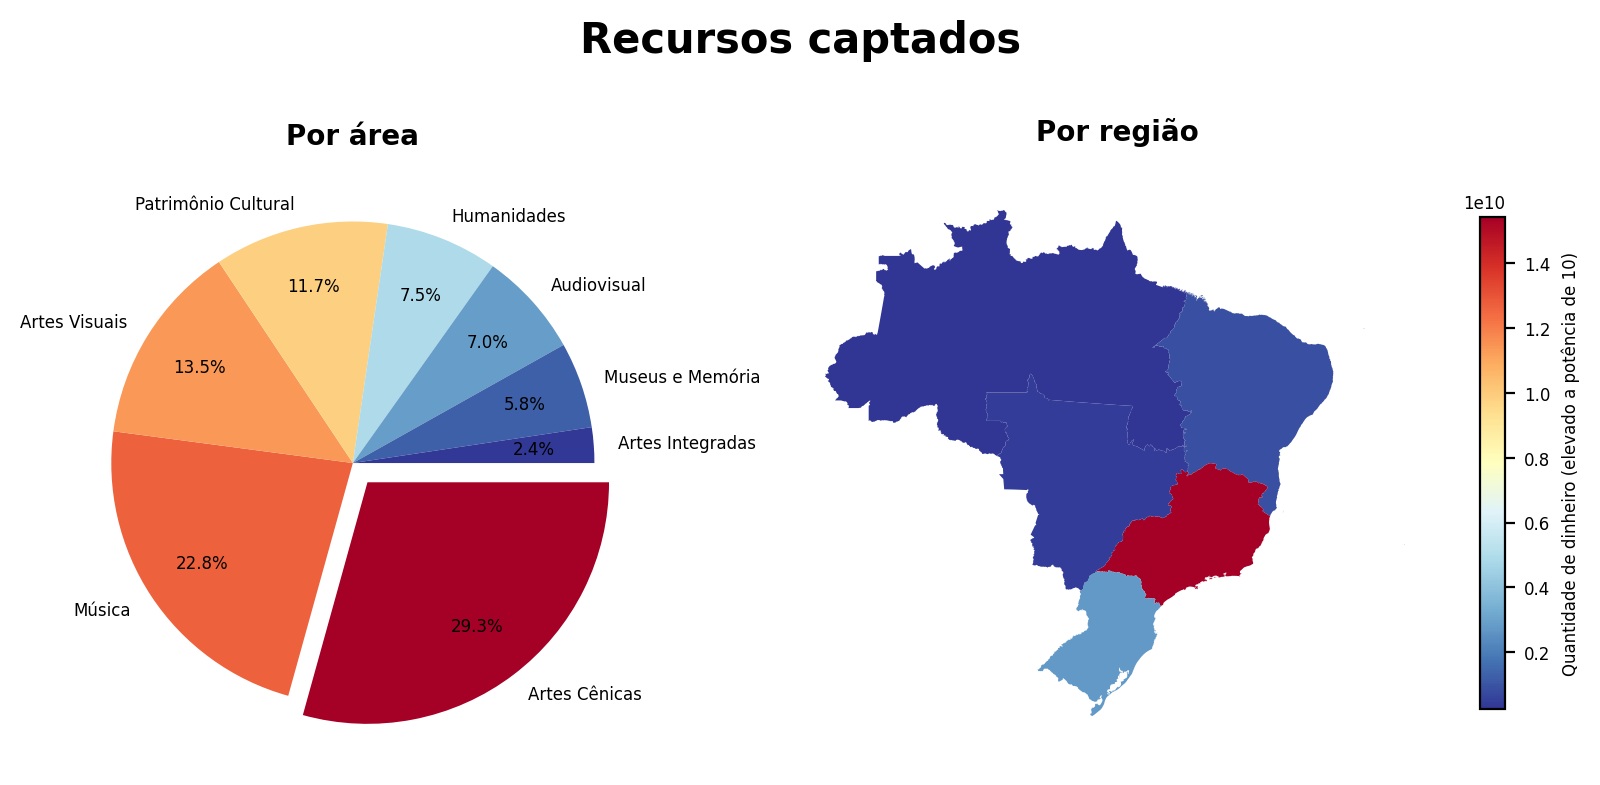

In [54]:
plt.rcParams.update({"font.size": 6})
cores = ["#A50026", "#EE613D", "#FA9857", "#FDD081", 
         "#AEDAE9", "#679DC9", "#3E60A9", "#313896"]
separacao_fatia_area = (0.1, 0, 0, 0, 0, 0, 0, 0)
separacao_fatia_regiao = (0.1, 0, 0, 0, 0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi=200, gridspec_kw={"width_ratios": [3, 4]})

ax1.pie(
    captacao_por_area.values.flatten(),
    labels=captacao_por_area.index,
    autopct="%1.1f%%",
    pctdistance=0.75,
    counterclock=False,
    colors=cores,
    explode=separacao_fatia_area
)

regioes.plot(
        column="total",
        cmap="RdYlBu_r",
        legend=True,
        legend_kwds={
            "label": "Quantidade de dinheiro (elevado a potência de 10)",
            "orientation": "vertical",
            "shrink": 0.8,
        },
        ax=ax2,
    )

ax2.axis("off")

fig.suptitle("Recursos captados", fontsize=15, fontweight=1000, y=1.05)
ax1.set_title("Por área", fontsize=10, fontweight=600)
ax2.set_title("Por região", fontsize=10, fontweight=600, y=1.05)

plt.savefig(path.abspath("charts/projetos_por_recursos01.png"), bbox_inches="tight")
plt.show()

In [55]:
def arredondamento_dinheiro(quantia):
    ordem = {
        3: (1, "mil"),
        4: (10, "mil"),
        5: (100, "mil"),
        6: (1, "mi"),
        7: (10, "mi"),
        8: (100, "mi"),
        9: (1, "bi"),
        10: (10, "bi"),
        11: (100, "bi"),
        12: (1, "tri")
    }
    quantia_texto = str(round(quantia)) if len(str(quantia)) > 3 else str(quantia)
    casas_decimais = len(quantia_texto) - 1
    numero, abreviacao = ordem.get(casas_decimais, (0, ""))
    if numero == 1:
        representacao_quantia = f"{quantia_texto[0]}.{quantia_texto[1]} {abreviacao}"
    elif numero == 10:
        representacao_quantia = f"{quantia_texto[:2]}.{quantia_texto[2]} {abreviacao}"
    elif numero == 100:
        representacao_quantia = f"{quantia_texto[:3]}.{quantia_texto[3]} {abreviacao}"
    else:
        representacao_quantia = f"{quantia}"
        
    return representacao_quantia

In [56]:
valor_aprovado_area_por_regiao = df_projetos.groupby(["area", "regiao"])["valor_aprovado"].sum().rename("total")
valor_aprovado_area_por_regiao = valor_aprovado_area_por_regiao.to_frame().unstack(level="area")["total"]

valor_captado_area_por_regiao = df_projetos.groupby(["area", "regiao"])["valor_captado"].sum().rename("total")
valor_captado_area_por_regiao = valor_captado_area_por_regiao.to_frame().unstack(level="area")["total"]

display(valor_aprovado_area_por_regiao, valor_captado_area_por_regiao)

area,Artes Cênicas,Artes Integradas,Artes Visuais,Audiovisual,Humanidades,Museus e Memória,Música,Patrimônio Cultural
regiao,,,,,,,,
Centro Oeste,4.899786e+08,1.011997e+07,2.483913e+08,1.281179e+08,1.009298e+08,1.550307e+08,7.747041e+08,5.344330e+08
Nordeste,9.902345e+08,4.836956e+07,2.657634e+08,2.248798e+08,2.931880e+08,1.983977e+08,1.202203e+09,6.090648e+08
Norte,2.377586e+08,2.925835e+06,1.294725e+08,4.893328e+07,4.892680e+07,5.133063e+06,2.252171e+08,1.160666e+08
Sudeste,1.187308e+10,6.565927e+08,5.912730e+09,2.973549e+09,3.027416e+09,2.842170e+09,8.876015e+09,4.790528e+09
Sul,2.642696e+09,9.400349e+07,7.425762e+08,3.952099e+08,5.249064e+08,3.342244e+08,1.946575e+09,6.875125e+08


area,Artes Cênicas,Artes Integradas,Artes Visuais,Audiovisual,Humanidades,Museus e Memória,Música,Patrimônio Cultural
regiao,,,,,,,,
Centro Oeste,1.187825e+08,4.900185e+06,5.686100e+07,3.279105e+07,1.795334e+07,8.624377e+06,1.478545e+08,7.183667e+07
Nordeste,2.140346e+08,2.329228e+07,4.507181e+07,6.723572e+07,8.097829e+07,3.863992e+07,2.685204e+08,1.384292e+08
Norte,6.585795e+07,8.968300e+05,3.547034e+07,1.493634e+07,9.468608e+06,3.936572e+05,6.481794e+07,4.098390e+07
Sudeste,4.296096e+09,3.894338e+08,2.303661e+09,1.153049e+09,1.178968e+09,9.400062e+08,3.341556e+09,1.832646e+09
Sul,1.091091e+09,5.046880e+07,2.332998e+08,1.200539e+08,1.962960e+08,1.487608e+08,6.759021e+08,2.201582e+08


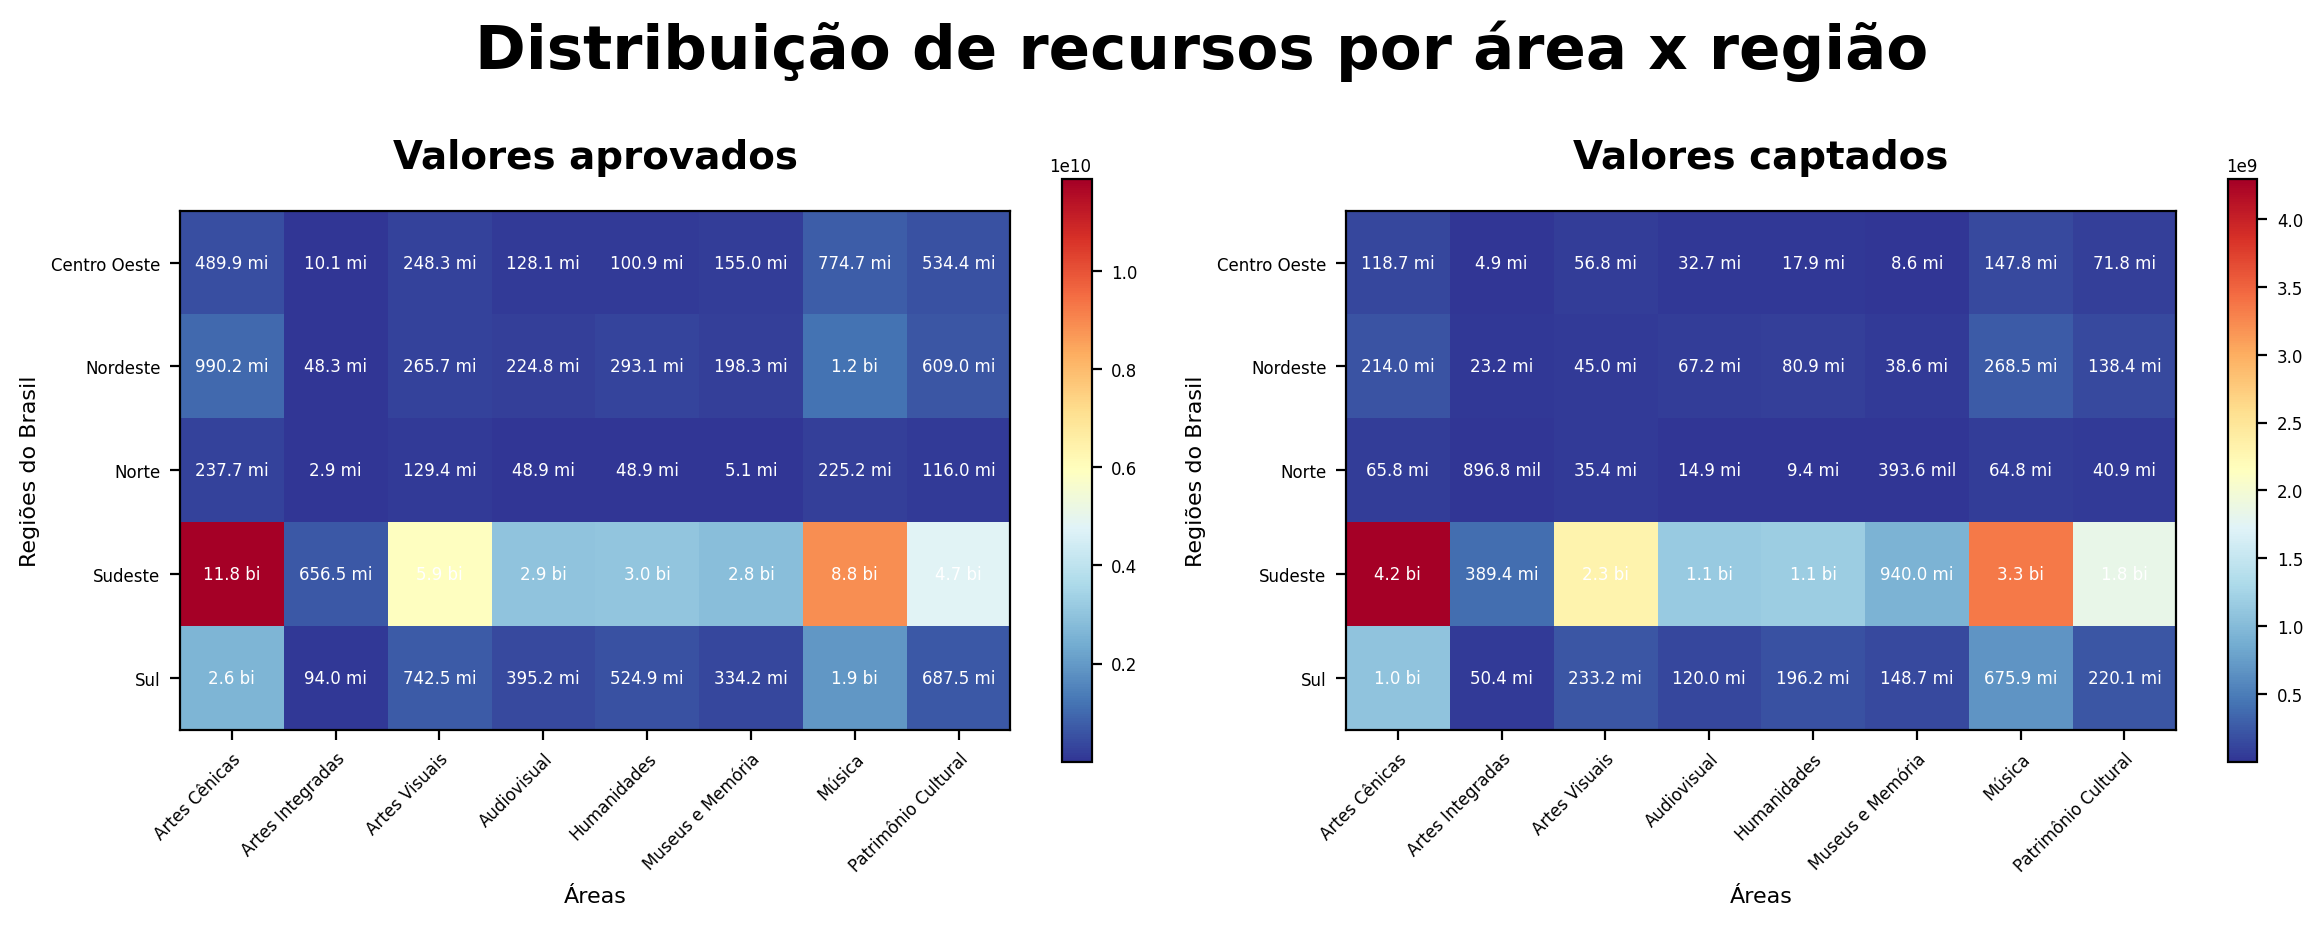

In [57]:
plt.rcParams.update({"font.size": 6})

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=200)

def heatmap(arr, axs):
    grafico = axs.imshow(
        arr.values,
        cmap="RdYlBu_r",
    )
    
    plt.setp(
        axs.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )
    
    plt.colorbar(grafico, ax=axs)
    
    for i in range(len(arr.index)):
        for j in range(len(arr.columns)):
            texto = axs.text(
                j, i,
                f"{arredondamento_dinheiro(arr.iloc[i, j])}",
                ha="center",
                va="center",
                color="#FFF"
            )
        
heatmap(valor_aprovado_area_por_regiao, ax1)
heatmap(valor_captado_area_por_regiao, ax2)

ax1.set_xticks(np.arange(len(valor_aprovado_area_por_regiao.columns)), labels=valor_aprovado_area_por_regiao.columns)
ax1.set_yticks(np.arange(len(valor_aprovado_area_por_regiao.index)), labels=valor_aprovado_area_por_regiao.index)
ax2.set_xticks(np.arange(len(valor_captado_area_por_regiao.columns)), labels=valor_captado_area_por_regiao.columns)
ax2.set_yticks(np.arange(len(valor_captado_area_por_regiao.index)), labels=valor_captado_area_por_regiao.index)

ax1.set_xlabel("Áreas", fontsize=8)
ax1.set_ylabel("Regiões do Brasil", fontsize=8)
ax2.set_xlabel("Áreas", fontsize=8)
ax2.set_ylabel("Regiões do Brasil", fontsize=8)

fig.suptitle("Distribuição de recursos por área x região", fontsize=22, fontweight=1000, y=1.05)
ax1.set_title("Valores aprovados", fontsize=14, fontweight=600, y=1.05)
ax2.set_title("Valores captados", fontsize=14, fontweight=600, y=1.05)

fig.tight_layout()
plt.savefig(path.abspath("charts/projetos_por_recursos02.png"), bbox_inches="tight")
plt.show()

#####

In [58]:
recursos_por_estado = df_projetos.groupby("UF")[["valor_aprovado", "valor_captado"]].sum().T
valor_captado_por_estado = recursos_por_estado.T["valor_captado"]
valor_aprovado_por_estado = recursos_por_estado.T["valor_aprovado"]
valor_captado_sobre_valor_aprovado_por_estado = (valor_captado_por_estado / valor_aprovado_por_estado * 100).rename("proporcao").to_frame()

display(recursos_por_estado, valor_captado_sobre_valor_aprovado_por_estado.T)

UF,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
valor_aprovado,6527132.22,50468464.53,1.548090e+08,13957898.24,1.075971e+09,7.801662e+08,1.256211e+09,6.871446e+08,8.652955e+08,3.806813e+08,...,2.375896e+09,1.158783e+10,1.068844e+08,55928650.76,7068296.96,3.392213e+09,1.599596e+09,76169174.92,2.230608e+10,41001899.52
valor_captado,974202.14,7888077.83,3.191499e+07,2028000.00,2.014162e+08,2.553100e+08,2.691258e+08,2.597790e+08,1.150058e+08,7.753439e+07,...,8.695565e+08,4.163780e+09,1.965181e+07,18779045.02,581564.41,1.293819e+09,5.726548e+08,14601549.00,8.796359e+09,6877271.27


UF,AC,AL,AM,AP,BA,CE,DF,ES,GO,MA,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
proporcao,14.925424,15.629716,20.615724,14.529408,18.71948,32.725075,21.423626,37.805585,13.290925,20.367272,...,36.599103,35.932335,18.386044,33.576789,8.227787,38.140856,35.799963,19.169893,39.434801,16.773055


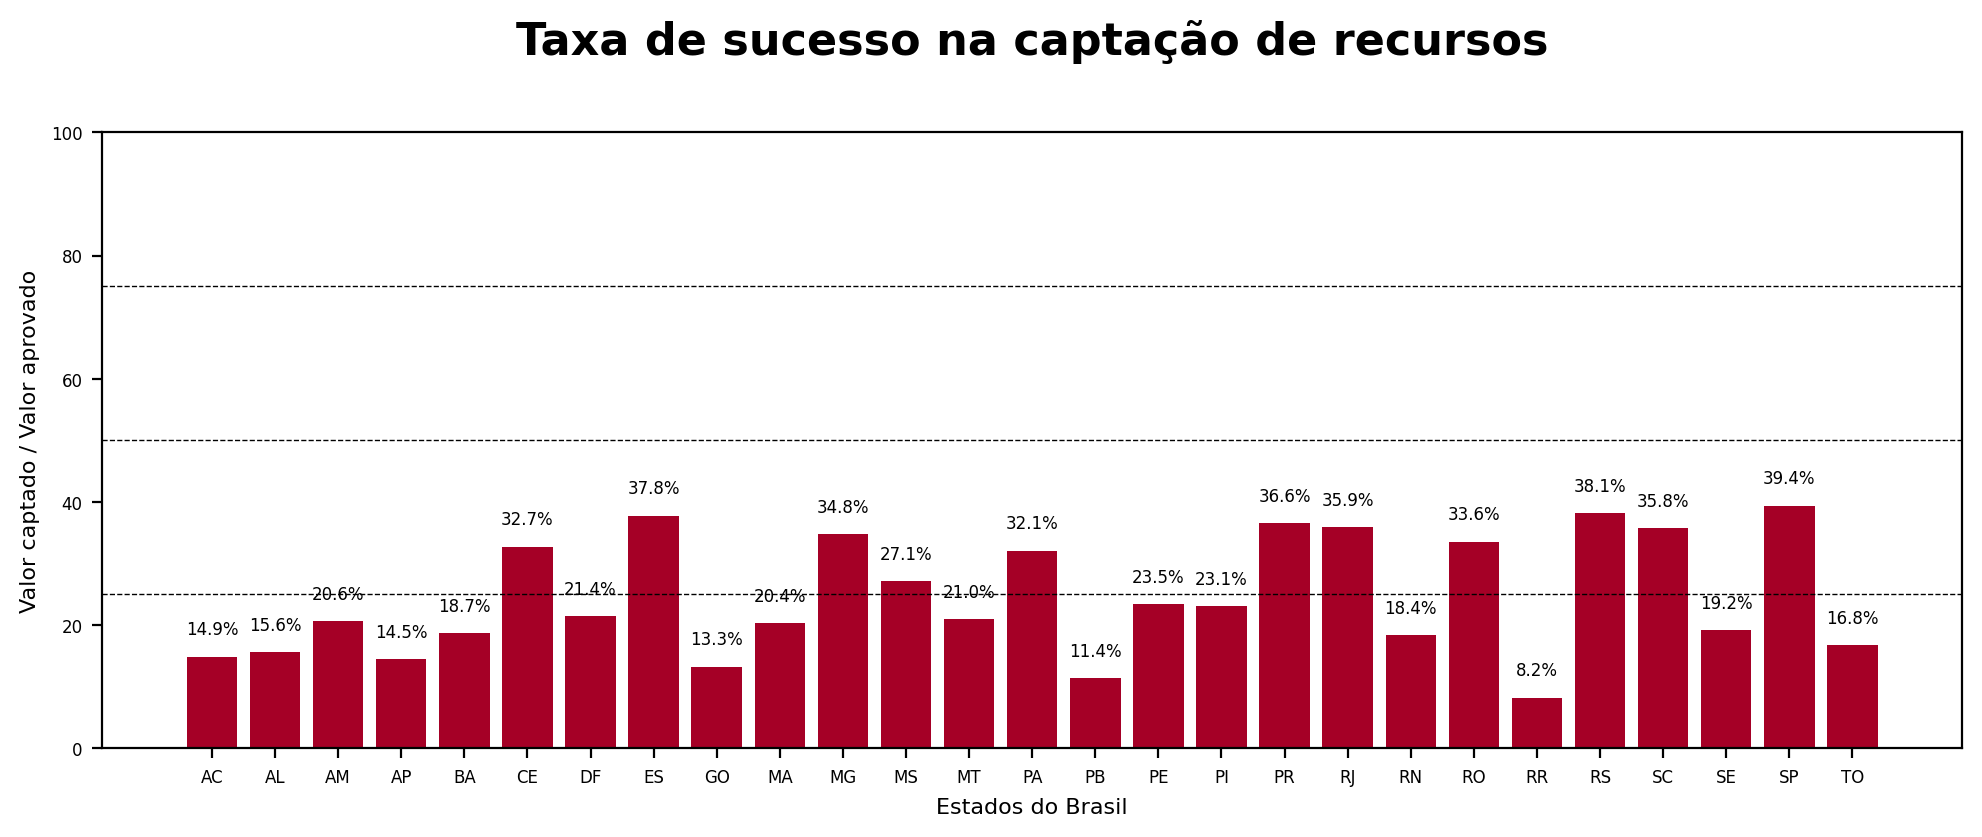

In [59]:
plt.rcParams.update({"font.size": 6})

figure, ax = plt.subplots(figsize=(12, 4), dpi=200)

plt.bar(
    valor_captado_sobre_valor_aprovado_por_estado.index,
    valor_captado_sobre_valor_aprovado_por_estado.values.flatten(),
    color="#A50026"
)

for x, y in zip(valor_captado_sobre_valor_aprovado_por_estado.index, valor_captado_sobre_valor_aprovado_por_estado.values.flatten()):
    ax.annotate(
        f"{y:.1f}%",
        (x, y),
        textcoords="offset points",
        xytext=(0, 8),
        ha="center"
    )

for i in range(25, 100, 25):
    plt.axhline(y=i, color="#000", linewidth=0.5, linestyle="dashed")

plt.xlabel("Estados do Brasil", fontsize=8)
plt.ylabel("Valor captado / Valor aprovado", fontsize=8)

plt.ylim(0, 100)

plt.title("Taxa de sucesso na captação de recursos", fontsize=16, fontweight=1000, y=1.1)

plt.savefig(path.abspath("charts/projetos_por_recursos03.png"), bbox_inches="tight")
plt.show()

#####

#### Exploração da distribuição de recursos financeiros ao longo do tempo

#####

#### Identificação dos projetos que receberam a maior e menor quantidade de financiamento

#####

#### Análise da dificuldade na captação de recursos

####

### 4.5. Influência de grandes projetos

#### Identificação e análise de grandes projetos que receberam um montante significativo de financiamento

###

## 5. Conclusão

### 5.1. Resumo das principais descobertas do projeto

#####

### 5.2. Identificação de padrões interessantes, tendências ao longo do tempo e insights valiosos para as partes interessadas e tomadores de decisão